# Create mask around Antarctic shelf
This code locates a given isobath (e.g., the 1000-m isobath) surrounding Antarctica and creates `mask_y_transport` and `mask_x_transport` masks to apply to the `vmo` and `umo` output on the MOM6 C-grid so that the net cross-isobath transport can be computed. This code was originally written by and adapted from Ruth Moorman at Caltech.

In [1]:
import numpy as np
import xarray as xr
import pandas as pd
#import cv2

import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
xr.__version__

'0.20.0'

In [3]:
cv2.__version__

'4.5.3'

## Load static grid file

In [4]:
rootdir = '/work/jet/static/'
grid_res = 'p125_d2' # p5, p25, p125, p125_d2
pp = 'ocean_monthly_d2' # ocean_monthly, ocean_monthly_d2

grid = xr.open_dataset(rootdir+'%s_%s.static.nc'%(grid_res,pp))

In [5]:
# Something is wrong with the indecies of the static grid file for p125_d2. Need to use indecies from dignostic output.
if pp.split('_')[-1]=='d2':
    ncdir = '/archive/Raphael.Dussin/FMS2019.01.03_devgfdl_20210706/CM4_piControl_c192_OM4p125_v7/gfdl.ncrc4-intel18-prod-openmp/pp/'
    ds = xr.open_mfdataset(ncdir+pp+'/ts/monthly/5yr/'+pp+'.0001*.*.nc', use_cftime=True, 
                           drop_variables=['average_DT','average_T1','average_T2'])
    
    grid = grid.assign_coords({'xh':ds.xh,'yh':ds.yh,'xq':ds.xq,'yq':ds.yq})

### Check grid indecies
The MOM6 output can be written in *symetric* (**len(Xq) = len(Xh) + 1**) or *non-symetric* mode (**len(Xq) = len(Xh)**), where **X** is a notation for both x and y. Here we want to make sure we use the same mode, and decided to base the calculations on non-symetric mode, such that we need to ensure that **len(Xq) = len(Xh)**.
We also want to be consistent with the convention that **Xh[i] < Xq[i]**, which means that the corners defined by `xq` are always to the east of the center defined by `xh`, and corners defined by `yq` are always to the north of the center defined by `yh`.

In [6]:
print('xh:',len(grid.xh),' xq:',len(grid.xq))
pd.concat([grid.xh.to_series().reset_index(drop=True), grid.xq.to_series().reset_index(drop=True)], axis=1)

xh: 1440  xq: 1441


,xh,xq
0,-298.604803,-298.649593
1,-298.372071,-298.417040
2,-298.139319,-298.184466
3,-297.906548,-297.951872
4,-297.673757,-297.719259
...,...,...
1436,60.464470,60.420396
1437,60.697121,60.652868
1438,60.929793,60.885360
1439,61.162485,61.117873


In [7]:
print('yh:',len(grid.yh),' yq:',len(grid.yq))
pd.concat([grid.yh.to_series().reset_index(drop=True), grid.yq.to_series().reset_index(drop=True)], axis=1)

yh: 1120  yq: 1121


,yh,yq
0,-83.622544,-83.642221
1,-83.543748,-83.563460
2,-83.464814,-83.484560
3,-83.385749,-83.405527
4,-83.306560,-83.326368
...,...,...
1116,89.589108,89.561715
1117,89.698679,89.671286
1118,89.808250,89.780857
1119,89.917822,89.890429


In [8]:
# Remove last entry in xq and yq in 1/8 deg grid 
if grid_res.split('_')[0]=='p125':
    if pp.split('_')[-1]=='d2':
        grid = grid.isel(xq=slice(1,None),yq=slice(1,None))
    else:
        grid = grid.isel(xq=slice(None,-1),yq=slice(None,-1))

In [9]:
print('xh:',len(grid.xh),' xq:',len(grid.xq))
pd.concat([grid.xh.to_series().reset_index(drop=True), grid.xq.to_series().reset_index(drop=True)], axis=1)

xh: 1440  xq: 1440


,xh,xq
0,-298.604803,-298.417040
1,-298.372071,-298.184466
2,-298.139319,-297.951872
3,-297.906548,-297.719259
4,-297.673757,-297.486626
...,...,...
1435,60.231839,60.420396
1436,60.464470,60.652868
1437,60.697121,60.885360
1438,60.929793,61.117873


In [10]:
print('yh:',len(grid.yh),' yq:',len(grid.yq))
pd.concat([grid.yh.to_series().reset_index(drop=True), grid.yq.to_series().reset_index(drop=True)], axis=1)

yh: 1120  yq: 1120


,yh,yq
0,-83.622544,-83.563460
1,-83.543748,-83.484560
2,-83.464814,-83.405527
3,-83.385749,-83.326368
4,-83.306560,-83.247089
...,...,...
1115,89.479536,89.561715
1116,89.589108,89.671286
1117,89.698679,89.780857
1118,89.808250,89.890429


##  Antarctic Bathymetry Contour
### Define parameters and extract relevant grid data
To be sure we only detence the Antarcitc shelf we set a northern boundary (i.e., 60S). We also want to define the isobath (e.g., 1000 m)

In [11]:
# Select northern boundary
lat_north = -60

# Contour depth
contour_depth = 1000

In [12]:
## Extract data from static file
bathy = grid.deptho.sel(yh=slice(None,lat_north))
land_mask = grid.wet.sel(yh=slice(None,lat_north))
geolon = grid.geolon.sel(yh = slice(None,lat_north))
geolat = grid.geolat.sel(yh = slice(None,lat_north))

### Initial basic bathymetry masking

In [13]:
#fills land values with ones for bathemetry field
temporary_mask = bathy.copy().fillna(1)
xh = temporary_mask.xh
yh = temporary_mask.yh

In [14]:
# Antarctic continent and shelf region filled with ones
temporary_mask = temporary_mask.where(temporary_mask <= contour_depth)*0 + 1

# Ocean values filled with zeros
temporary_mask = temporary_mask.fillna(0)

# Extract numpy array
temporary_mask = temporary_mask.values

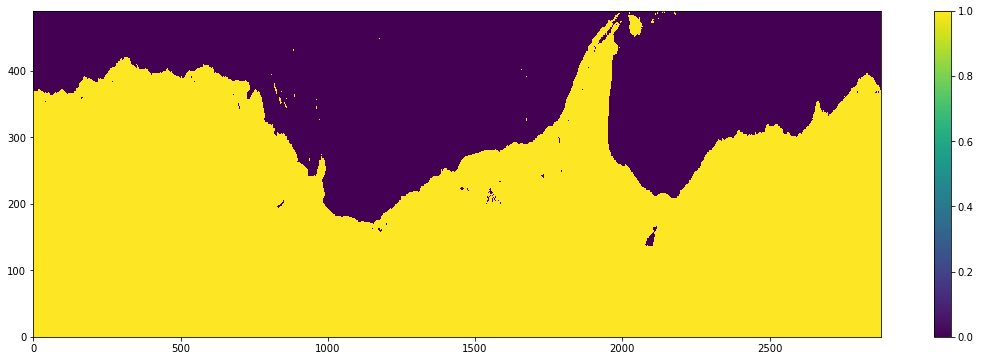

In [15]:
plt.figure(figsize=[19,6])
plt.pcolormesh(temporary_mask) #plot numpy array
plt.colorbar()

In [16]:
# # this spreads the isobath contour so all points are connected adjacently (not just diagonally):
kernel = np.ones((3,3),np.uint8) ## 8 bit unsigned integer type (no sign (+/-) attached),
#creates a 3 x 3 array of ones

# cv2.dilate = morphological transformation. Needs two inputs: the original image (temporary_mask)
# and the structuring element or kernel which decides the nature of the operation.
# Dilation increases the white region in the image or the size of the foreground object increases.

contour_mask0 = cv2.dilate(temporary_mask,kernel,iterations=1) - temporary_mask

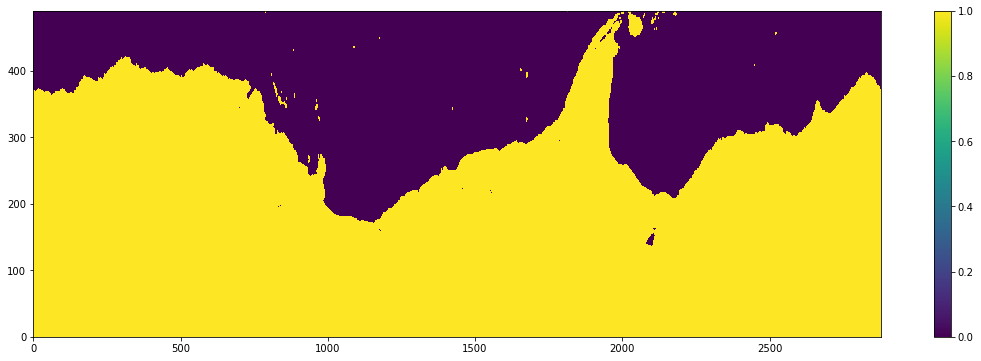

In [17]:
plt.figure(figsize=[19,6])
plt.pcolormesh(cv2.dilate(temporary_mask,kernel,iterations=1))
plt.colorbar()

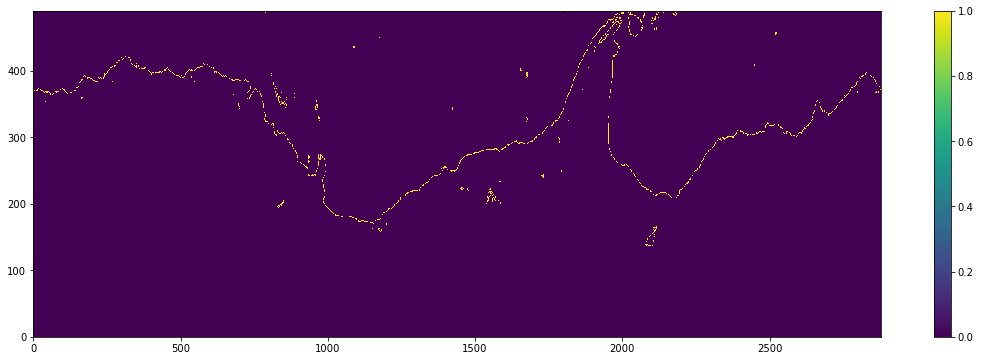

In [18]:
plt.figure(figsize=[19,6])
plt.pcolormesh(contour_mask0)
plt.colorbar()

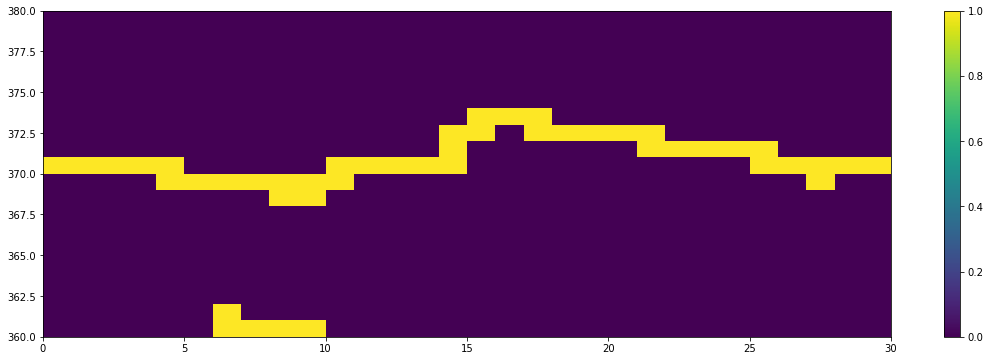

In [20]:
plt.figure(figsize=[19,6])
plt.pcolormesh(contour_mask0)
plt.xlim([None,30])
#plt.ylim([57,66]) # p5
#plt.ylim([175,190]) # p25 d2
plt.ylim([360,380]) # p125
plt.colorbar()

In [21]:
# Start at western edge of domain, at y point closest to correct depth contour:
contour_mask = np.zeros_like(land_mask.values)  #land values zeros

contour_lat_index_start = np.where(contour_mask0[:,0]>0)[0][0]
#returns tuple integer positions NOT values where greater than zero along the first column.
# selects first element of tuple and first element of the array (first element can also be indexed as -1)

contour_mask[contour_lat_index_start,0] = 1
# This is the equivalent of position [142,0]. Make this position = 1.

In [22]:
contour_lat_index_start

370

In [23]:
(len(xh)-1)

2879

In [24]:
if grid_res=='p5':
    force_south = [228]
    force_north = [239]
elif grid_res=='p25':
    force_south = [471,1453,1454,1459,2111]
    force_north = [679,698]
elif grid_res.split('_')[0]=='p125':
    if pp.split('_')[-1]=='d2':
        force_south = [553,582,1484]
        force_north = [691]
    else:
        force_south = [1267,1650,3189]
        force_north = [190,1542,2003,2916,4636]

In [25]:
# Loop through to find adjacent point closest to contour depth (do not include previous point):
last_index_i = 0
last_index_j = contour_lat_index_start
count = 0

while last_index_i<(len(xh)-1): # 2880(p125)/1440(p25)/720(p5) is xh dimension length
    print(count, last_index_i, last_index_j)
    #This code block says that for the first time don't go backwards:
    
    # If statement says for the first (most west) point, where last_index_i == 0,
    # create an array called "points to compare" which is composed of 4 elements:
    # 1) The value of the element to the EAST (right)
    # 2) The value of the element to the WEST (left) ---> In this case we set this to zero for the first pt.
    # 3) The value of the element to the NORTH 
    # 4) The value of the element to the SOUTH
    
    if last_index_i == 0:
        points_to_compare = np.array([contour_mask0[last_index_j, last_index_i+1], 0,
                                      contour_mask0[last_index_j+1, last_index_i],
                                      contour_mask0[last_index_j-1, last_index_i]])
    else:
        points_to_compare = np.array([contour_mask0[last_index_j,last_index_i+1],
                                      contour_mask0[last_index_j,last_index_i-1],
                                      contour_mask0[last_index_j+1,last_index_i],
                                      contour_mask0[last_index_j-1,last_index_i]])
        
    print(points_to_compare)
    #if count==485:
    #    last_index_i=(len(xh)-1)
    #    continue411

    # This line, new_loc = np.where(points_to_compare==1) produces a tuple that 
    # contains an array as its first element [0]. The array contains the INDEXES or positions in 
    # the "points to compare" array that have values equal to 1 (i.e, where the 1000 m isobath exists)
    
    # the [0] at the end of the statement says to take the first element of the tuple, which is the array of the 
    # indexes for points where values are 1.
    
    # For the first point, where last_index_i == 0, this results in points_to_compare = array[1,0,0,0]
    # And the the new_loc = array([0]). The new_loc has a length of 1 in this case ... which comes in next 
    # (see below)
    new_loc = np.where(points_to_compare==1)[0]
    
    # THIS CODE BLOCK GIVES EACH POINT ALONG THE CONTOUR A UNIQUE INDEX NUMBER:
    # In the first if statement, do the following if the length of new_loc == 0, meaning
    # the array contains no elements. This would mean that there are no neighboring cells that have 
    # values of 1. This would indicate a discontinuity in the contour ... I don't think this 
    # is possible so is this necessary?
    
    if len(new_loc)==0:
        print('Discontinuity in the contour!')
        contour_mask[last_index_j,last_index_i] = 0
        contour_mask0[last_index_j,last_index_i] = 0
        #contour_mask0[contour_mask==count] = 0
        print('j'+str(last_index_j)+'i'+str(last_index_i))
        count = count - 1
        last_index_i = np.where(contour_mask==count+1)[1][0]
        last_index_j = np.where(contour_mask==count+1)[0][0]
        continue
        
    # IF length of new_loc > 0, meaning there is at least 1 element in the points_to_compare array
    # equal to 1, thus there is at least one cell to the east, west, north, or south that is along
    # the 1,000 m isobath.
    
    # new_loc is an array that contains the indexes of where in the points_to_compare array that
    # values are equal to one. So, in theory, it can have a length of 0 (no points -- see above), 
    # 1, 2, 3, or 4 (all points) around the value are equal to 1 ... point is completely surrounded. 
    
    elif len(new_loc)>0:
        
        # Special cases to avoid strange loops
        if count in force_south:
            print('Forced to go south!')
            new_index_i = last_index_i
            new_index_j = last_index_j-1
            
        elif count in force_north:
            print('Forced to go north!')
            new_index_i = last_index_i
            new_index_j = last_index_j+1
        
        # In some cases ther are multiple directions possible
        # The if loop below prioritizes east, then west, then north, then south
        # In a few instances, this can cause the contour to create pesky enclosed loops,
        # The above statement forces the direction to avoid those loops
            
        # if the first element of the array is 0 this means that the
        # point to the east (right) of the cell has value of 1
        # so keep the same y value (last_index_j) but move to the right by one: last_index_i+1
        #elif new_loc[0] == 0:
        if new_loc[0] == 0:
            print('Go east!')
            new_index_i = last_index_i+1
            new_index_j = last_index_j
            
        # if the first element of the array is 1 this means that the   
        # point to the west (left) of the cell has value of 1
        # so keep the same y value (last_index_j) but move to the right by one: last_index_i+1 
        elif new_loc[0] == 1:
            print('Go west!')
            new_index_i = last_index_i-1
            new_index_j = last_index_j
            
        # if the first element of the array is 2 this means that the  
        # point to the north of the cell has value of 1
        # so keep the same x value (last_index_i) but move to the north (up) by one: last_index_j+1
        elif new_loc[0] == 2:
            print('Go north!')
            new_index_i = last_index_i
            new_index_j = last_index_j+1
            
        # if the first element of the array is 3 this means that the  
        # point to the south of the cell has value of 1
        # so keep the same x value (last_index_i) but move to the south (down) by one: last_index_j-1
        elif new_loc[0] == 3:
            print('Go south!')
            new_index_i = last_index_i
            new_index_j = last_index_j-1
            
        # The original count = 0, so count + 2 means that the second point on the contour_mask array
        # will be called 2 ... remember above we made the first point = 1. So as we go this will number
        # all the points.
        contour_mask[new_index_j,new_index_i] = count + 2
        
        # The current point will be labeled "2" so that we only find new points and not go backwards
        contour_mask0[last_index_j,last_index_i] = 2
        
        # Now we move forward along the contour by updating the indexes 
        last_index_j = new_index_j
        last_index_i = new_index_i
        
        # Add one to the count value ... it starts at 0, so will go 1, 2, 3 .... 
        # until the while condition at the start of this code block is FALSE.
        count += 1
        
    ### THIS IS THE END OF THE WHILE LOOP.

0 0 370
[1. 0. 0. 0.]
Go east!
1 1 370
[1. 2. 0. 0.]
Go east!
2 2 370
[1. 2. 0. 0.]
Go east!
3 3 370
[1. 2. 0. 0.]
Go east!
4 4 370
[0. 2. 0. 1.]
Go south!
5 4 369
[1. 0. 2. 0.]
Go east!
6 5 369
[1. 2. 0. 0.]
Go east!
7 6 369
[1. 2. 0. 0.]
Go east!
8 7 369
[1. 2. 0. 0.]
Go east!
9 8 369
[1. 2. 0. 1.]
Go east!
10 9 369
[1. 2. 0. 1.]
Go east!
11 10 369
[0. 2. 1. 0.]
Go north!
12 10 370
[1. 0. 0. 2.]
Go east!
13 11 370
[1. 2. 0. 0.]
Go east!
14 12 370
[1. 2. 0. 0.]
Go east!
15 13 370
[1. 2. 0. 0.]
Go east!
16 14 370
[0. 2. 1. 0.]
Go north!
17 14 371
[0. 0. 1. 2.]
Go north!
18 14 372
[1. 0. 0. 2.]
Go east!
19 15 372
[0. 2. 1. 0.]
Go north!
20 15 373
[1. 0. 0. 2.]
Go east!
21 16 373
[1. 2. 0. 0.]
Go east!
22 17 373
[0. 2. 0. 1.]
Go south!
23 17 372
[1. 0. 2. 0.]
Go east!
24 18 372
[1. 2. 0. 0.]
Go east!
25 19 372
[1. 2. 0. 0.]
Go east!
26 20 372
[1. 2. 0. 0.]
Go east!
27 21 372
[0. 2. 0. 1.]
Go south!
28 21 371
[1. 0. 2. 0.]
Go east!
29 22 371
[1. 2. 0. 0.]
Go east!
30 23 371
[1. 2. 0. 0.]


#### Same loop but with graphical output saved as PDF (This is going to take a couple of minutes)

In [25]:
from matplotlib.backends.backend_pdf import PdfPages

In [26]:
#first_index_pdf = 30
first_index_pdf = 450

# Loop through to find adjacent point closest to contour depth (do not include previous point):
last_index_i = 0
last_index_j = contour_lat_index_start
count = 0

with PdfPages('/work/jet/figure.pdf') as pdf:
    while last_index_i<(len(xh)-1):
    #while last_index_i<2030:
        print(count, last_index_i, last_index_j)
        if last_index_i == 0:
            points_to_compare = np.array([contour_mask0[last_index_j, last_index_i+1], 0,
                                          contour_mask0[last_index_j+1, last_index_i],
                                          contour_mask0[last_index_j-1, last_index_i]])
        else:
            points_to_compare = np.array([contour_mask0[last_index_j,last_index_i+1],
                                          contour_mask0[last_index_j,last_index_i-1],
                                          contour_mask0[last_index_j+1,last_index_i],
                                          contour_mask0[last_index_j-1,last_index_i]])
        print(points_to_compare)
        #if count==411:
        #    last_index_i=len(xh)-1
        #    continue
        
        new_loc = np.where(points_to_compare==1)[0]
        
        if last_index_i>first_index_pdf:
            
            if last_index_j>=10:
                yidx = np.arange(len(yh))[int(np.floor(last_index_j/10)*10-10):int(np.ceil(last_index_j/10)*10+10)]
                xidx = np.arange(len(xh))[int(np.floor(last_index_i/10)*10-10):int(np.ceil(last_index_i/10)*10+10)]
                data = contour_mask[int(np.floor(last_index_j/10)*10-10):int(np.ceil(last_index_j/10)*10+10),
                                    int(np.floor(last_index_i/10)*10-10):int(np.ceil(last_index_i/10)*10+10)]
                
            else:
                yidx = np.arange(len(yh))[0:int(np.ceil(last_index_j/10)*10+10)]
                xidx = np.arange(len(xh))[int(np.floor(last_index_i/10)*10-10):int(np.ceil(last_index_i/10)*10+10)]
                data = contour_mask[0:int(np.ceil(last_index_j/10)*10+10),
                                    int(np.floor(last_index_i/10)*10-10):int(np.ceil(last_index_i/10)*10+10)]
                
            plt.figure(figsize=[15,10])
            plt.pcolormesh(xidx,yidx,data,shading='auto',
                           vmin=np.min(data[np.where(data>0)]),vmax=np.max(data[np.where(data>0)]))
            plt.colorbar()
            plt.yticks(yidx)
            plt.xticks(xidx)
            for y in range(data.shape[0]):
                for x in range(data.shape[1]):
                    if data[y, x]==0:
                        continue
                    else:
                        plt.text(xidx[x], yidx[y], '%.0f' %data[y, x], horizontalalignment='center',
                                 verticalalignment='center')
            pdf.savefig()
            plt.close()
        
        if len(new_loc)==0:
            print('Discontinuity in the contour!')
            contour_mask[last_index_j,last_index_i] = 0
            contour_mask0[last_index_j,last_index_i] = 0
            #contour_mask0[contour_mask==count] = 0
            print('j'+str(last_index_j)+'i'+str(last_index_i))
            count = count - 1
            last_index_i = np.where(contour_mask==count+1)[1][0]
            last_index_j = np.where(contour_mask==count+1)[0][0]
            continue
            
        elif len(new_loc)>0:
            
            # Special cases to avoid strange loops
            if count in [553,582,1484]:
                print('Forced to go south!')
                new_index_i = last_index_i
                new_index_j = last_index_j-1
                
            elif count in [691]:
                print('Forced to go north!')
                new_index_i = last_index_i
                new_index_j = last_index_j+1
            
            elif new_loc[0] == 0:
            #if new_loc[0] == 0:
                print('Go east!')
                new_index_i = last_index_i+1
                new_index_j = last_index_j
                
            elif new_loc[0] == 1:
                print('Go west!')
                new_index_i = last_index_i-1
                new_index_j = last_index_j
                
            elif new_loc[0] == 2:
                print('Go north!')
                new_index_i = last_index_i
                new_index_j = last_index_j+1
                
            elif new_loc[0] == 3:
                print('Go south!')
                new_index_i = last_index_i
                new_index_j = last_index_j-1
                
            contour_mask[new_index_j,new_index_i] = count + 2
            contour_mask0[last_index_j,last_index_i] = 2
            last_index_j = new_index_j
            last_index_i = new_index_i
            count += 1

0 0 185
[1. 0. 0. 0.]
Go east!
1 1 185
[1. 2. 0. 0.]
Go east!
2 2 185
[1. 2. 0. 0.]
Go east!
3 3 185
[1. 2. 0. 1.]
Go east!
4 4 185
[1. 2. 0. 1.]
Go east!
5 5 185
[1. 2. 0. 0.]
Go east!
6 6 185
[0. 2. 1. 0.]
Go north!
7 6 186
[1. 0. 0. 2.]
Go east!
8 7 186
[1. 2. 0. 0.]
Go east!
9 8 186
[1. 2. 0. 0.]
Go east!
10 9 186
[1. 2. 0. 0.]
Go east!
11 10 186
[1. 2. 0. 0.]
Go east!
12 11 186
[1. 2. 0. 0.]
Go east!
13 12 186
[0. 2. 0. 1.]
Go south!
14 12 185
[1. 0. 2. 0.]
Go east!
15 13 185
[1. 2. 0. 0.]
Go east!
16 14 185
[1. 2. 0. 0.]
Go east!
17 15 185
[1. 2. 0. 0.]
Go east!
18 16 185
[0. 2. 0. 1.]
Go south!
19 16 184
[1. 0. 2. 0.]
Go east!
20 17 184
[1. 2. 0. 0.]
Go east!
21 18 184
[1. 2. 0. 1.]
Go east!
22 19 184
[1. 2. 0. 1.]
Go east!
23 20 184
[1. 2. 0. 0.]
Go east!
24 21 184
[1. 2. 0. 0.]
Go east!
25 22 184
[1. 2. 0. 0.]
Go east!
26 23 184
[1. 2. 0. 0.]
Go east!
27 24 184
[1. 2. 0. 0.]
Go east!
28 25 184
[1. 2. 0. 0.]
Go east!
29 26 184
[1. 2. 0. 0.]
Go east!
30 27 184
[0. 2. 0. 1.]
Go s

### Check contour

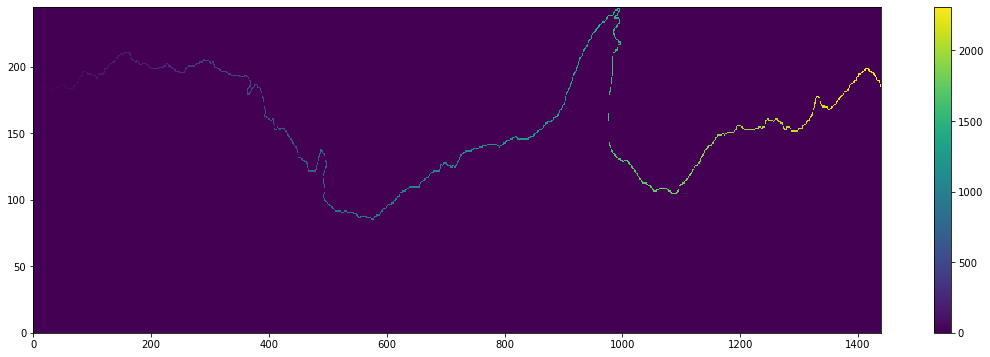

In [27]:
plt.figure(figsize=[19,6])
plt.pcolormesh(contour_mask)
plt.colorbar()

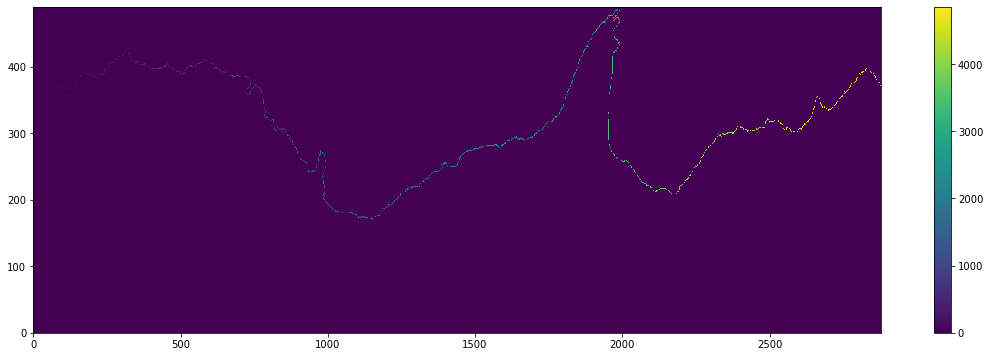

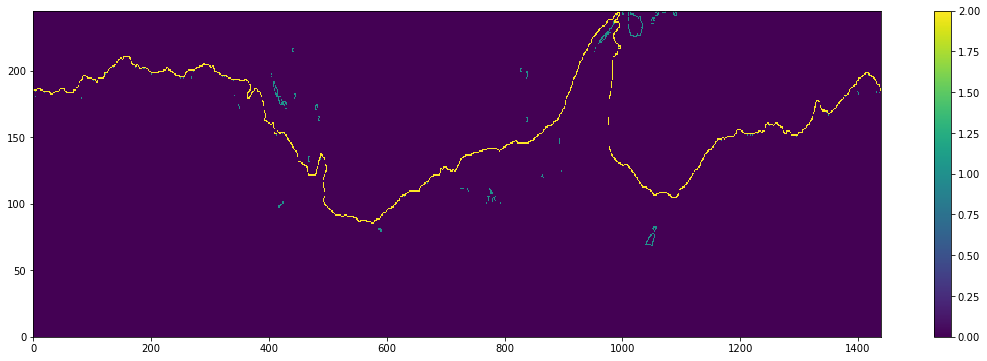

In [28]:
plt.figure(figsize=[19,6])
plt.pcolormesh(contour_mask0)
plt.colorbar()

#### Zoom in an plot specific sections of the contour

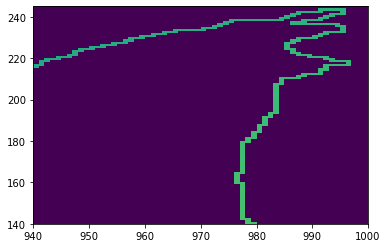

In [29]:
plt.pcolormesh(contour_mask)
#plt.xlim([1900,2000]) #p125
#plt.ylim([300,None]) #p125
plt.xlim([940,1000]) #p125-d2
plt.ylim([140,None]) #p125-d2
#plt.xlim([960,1000]) #p25
#plt.ylim([74,200]) #p25
#plt.xlim([480.0,500]) #p5
#plt.ylim([37,None]) #p5
plt.show()

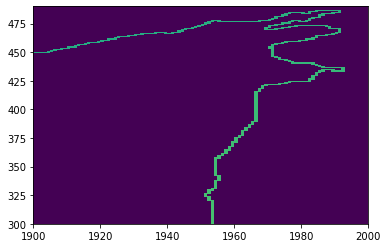

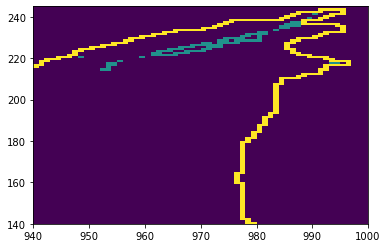

In [33]:
plt.pcolormesh(contour_mask0)
#plt.xlim([1900,2000]) #p125
#plt.ylim([300,None]) #p125
plt.xlim([940,1000]) #p125-d2
plt.ylim([140,None]) #p125-d2
#plt.xlim([960,1000]) #p25
#plt.ylim([74,200]) #p25
#plt.xlim([480.0,500]) #p5
#plt.ylim([37,None]) #p5
plt.show()

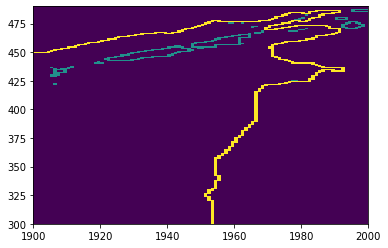

(75.0, 200.0)

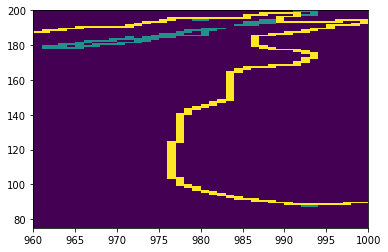

In [29]:
#p25
yidx = np.arange(130,150)
xidx = np.arange(360,372)
data = contour_mask[130:150,360:372]
data0 = contour_mask0[130:150,360:372]

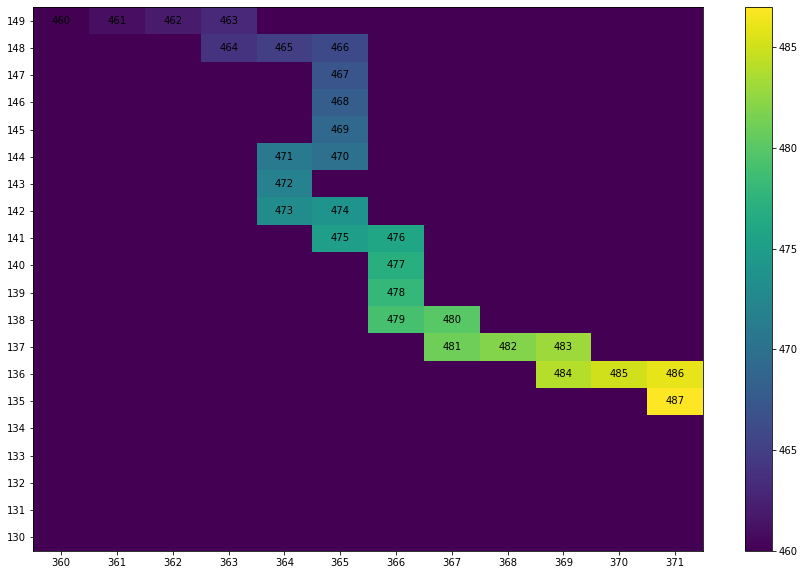

In [23]:
plt.figure(figsize=[15,10])
plt.pcolormesh(xidx,yidx,data,shading='auto',
               vmin=np.min(data[np.where(data>0)]),vmax=np.max(data[np.where(data>0)]))
plt.colorbar()
plt.yticks(yidx)
plt.xticks(xidx)
for y in range(data.shape[0]):
    for x in range(data.shape[1]):
        if data[y, x]==0:
            continue
        else:
            plt.text(xidx[x], yidx[y], '%.0f' %data[y, x], horizontalalignment='center',
                     verticalalignment='center')   
plt.show()

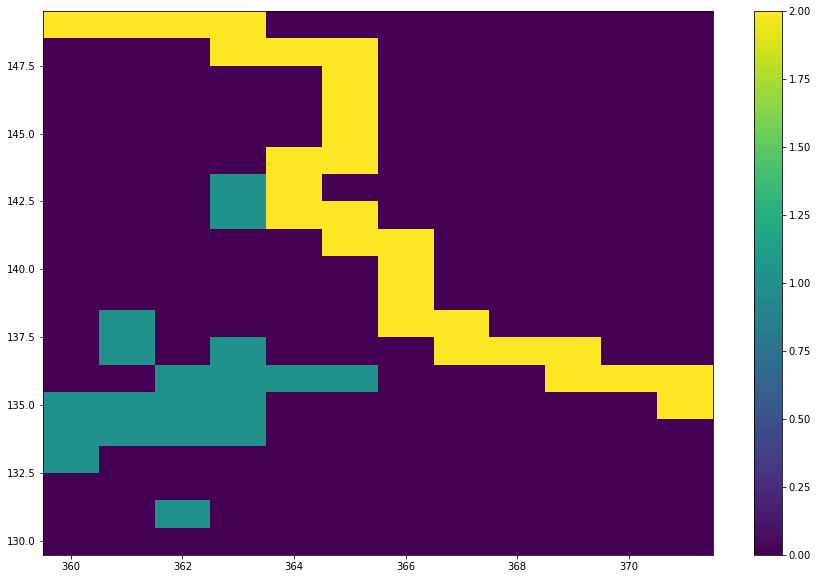

In [24]:
plt.figure(figsize=[15,10])
plt.pcolormesh(xidx,yidx,data0,shading='auto')
plt.colorbar()

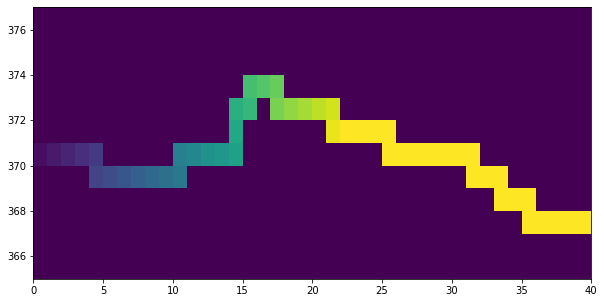

In [30]:
plt.figure(figsize=[10,5])
plt.pcolormesh(contour_mask,vmax=30)
plt.xlim([0,40])
#plt.ylim([137,145]) #p25
plt.ylim([365,377]) #p125
plt.show()

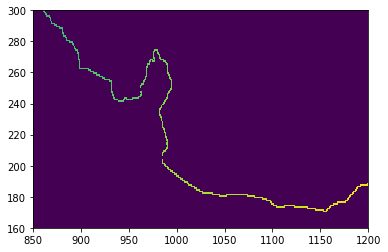

In [39]:
plt.pcolormesh(contour_mask,vmax=2000)
#plt.xlim([400,600]) #p25
#plt.ylim([45,125]) #p25
plt.xlim([850,1200]) #p25
plt.ylim([160,300]) #p25
#plt.colorbar()
plt.show()

(45.0, 125.0)

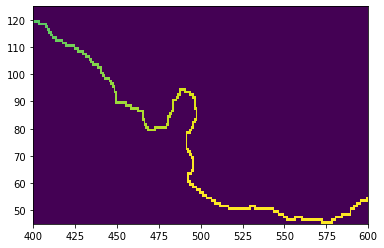

### Fill in points to create the shelf mask (south of the contour)
This code block creates a mask where values above the 1000 m isobath are equal to -100 and values equal to and below are zero.

In [34]:
# This is the sequentially numbered isobath created in the while loop above that provides an along isobath index.
# It is an array of zeros EXCEPT for the contour which is 1 through whatever the last index is.
contour_mask_numbered = contour_mask

# Make a copy of the array.
contour_masked_above = np.copy(contour_mask_numbered)

# Replace first x point and first y point with -100
contour_masked_above[-1,0] = -100

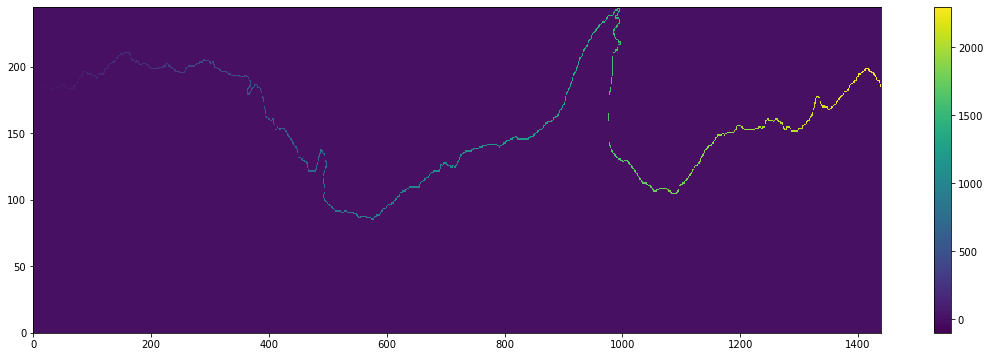

In [35]:
plt.figure(figsize=[19,6])
plt.pcolormesh(contour_masked_above)
plt.colorbar()
plt.show()

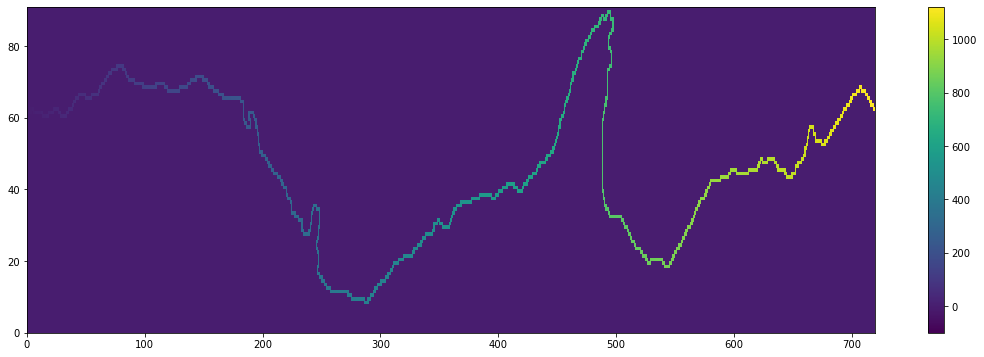

In [36]:
# From top left:
for ii in range(len(xh)-1):
    for jj in range(len(yh))[::-1][:-1]:
        if contour_masked_above[jj,ii] == -100:
            if contour_masked_above[jj-1,ii] == 0:
                contour_masked_above[jj-1,ii] = -100
            if contour_masked_above[jj,ii+1] == 0:
                contour_masked_above[jj,ii+1] = -100
            if contour_masked_above[jj-1,ii+1] == 0:
                contour_masked_above[jj-1,ii+1] = -100

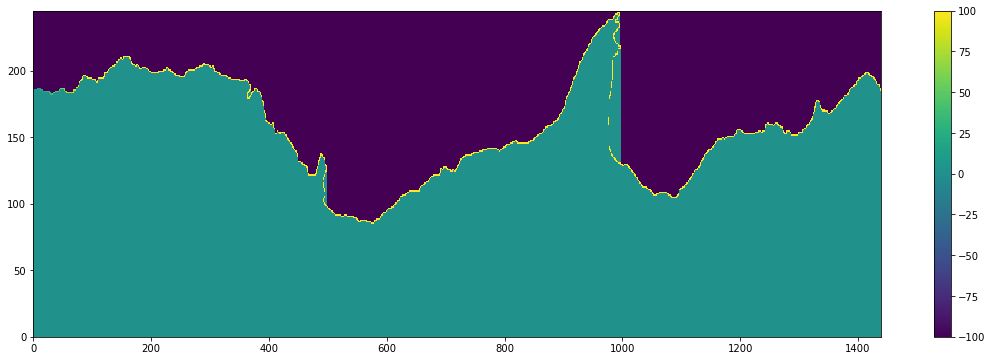

In [37]:
plt.figure(figsize=[19,6])
plt.pcolormesh(contour_masked_above,vmax=100)
plt.colorbar()
plt.show()

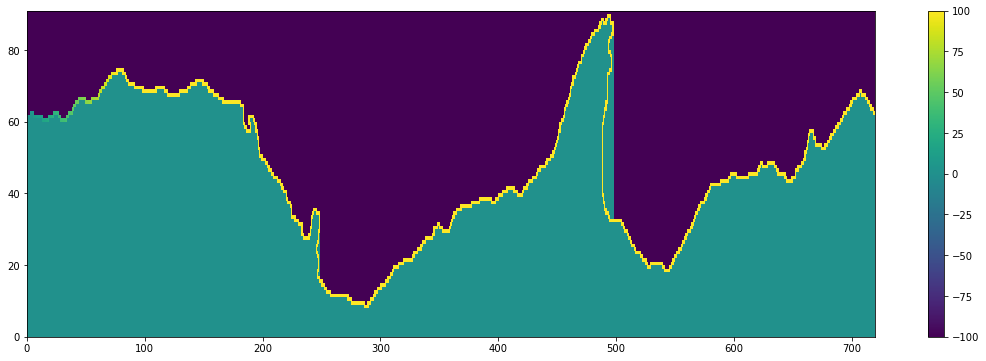

In [38]:
# From top right:
for ii in range(len(xh))[::-1][:-1]:
    for jj in range(len(yh))[::-1][:-1]:
        if contour_masked_above[jj,ii] == -100:
            if contour_masked_above[jj-1,ii] == 0:
                contour_masked_above[jj-1,ii] = -100
            if contour_masked_above[jj,ii-1] == 0:
                contour_masked_above[jj,ii-1] = -100
            if contour_masked_above[jj-1,ii-1] == 0:
                contour_masked_above[jj-1,ii-1] = -100

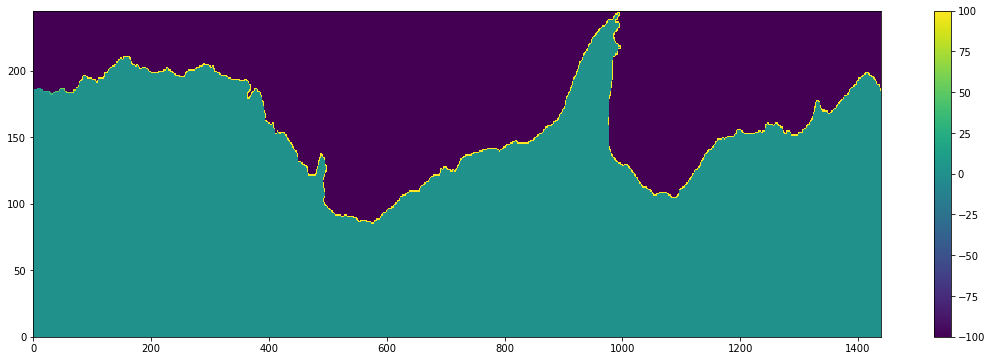

In [39]:
plt.figure(figsize=[19,6])
plt.pcolormesh(contour_masked_above,vmax=100)
plt.colorbar()
plt.show()

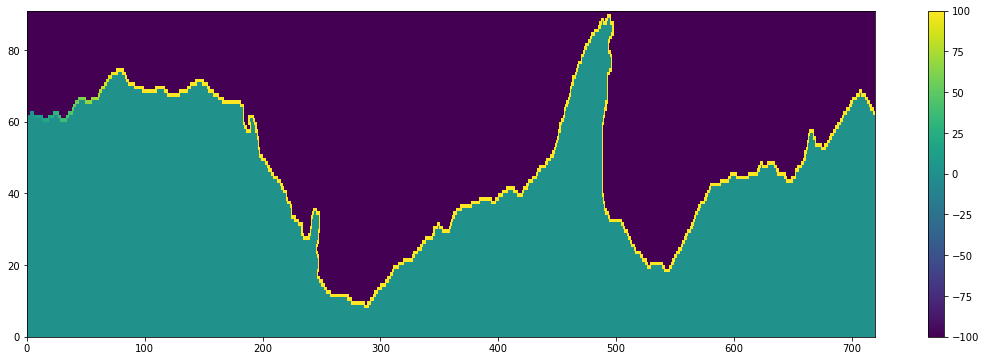

In [40]:
# From bottom right:
for ii in range(len(xh))[::-1][:-1]:
    for jj in range(len(yh)-1):
        if contour_masked_above[jj,ii] == -100:
            if contour_masked_above[jj+1,ii] == 0:
                contour_masked_above[jj+1,ii] = -100
            if contour_masked_above[jj,ii-1] == 0:
                contour_masked_above[jj,ii-1] = -100
            if contour_masked_above[jj+1,ii-1] == 0:
                contour_masked_above[jj+1,ii-1] = -100

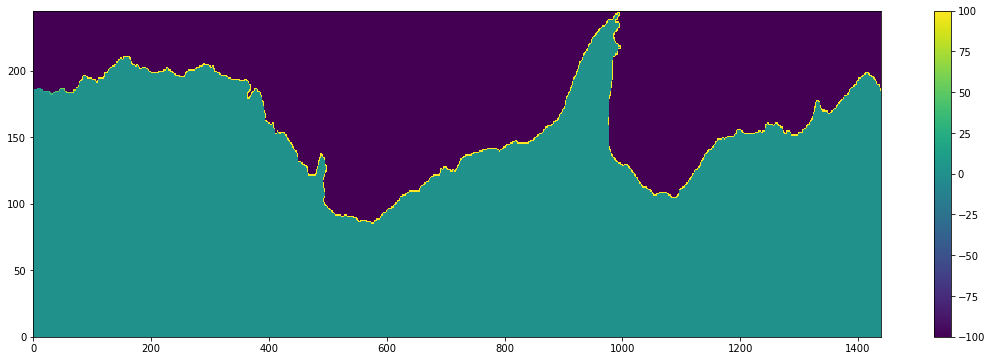

In [41]:
plt.figure(figsize=[19,6])
plt.pcolormesh(contour_masked_above,vmax=100)
plt.colorbar()
plt.show()

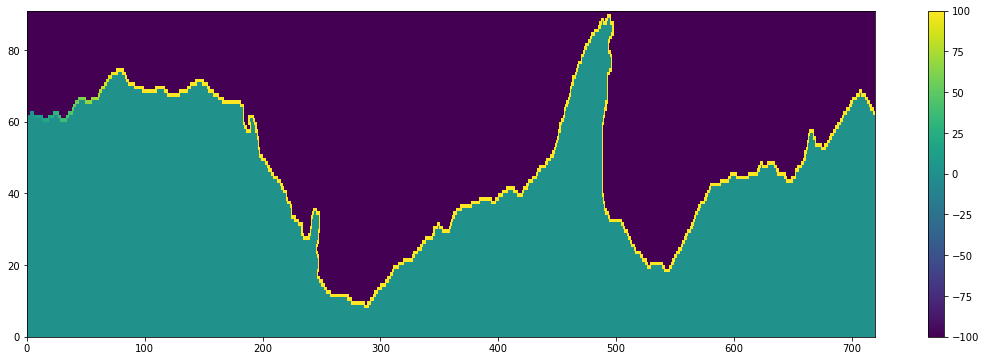

In [42]:
# From bottom left:
for ii in range(len(xh)-1):
    for jj in range(len(yh)-1):
        if contour_masked_above[jj,ii] == -100:
            if contour_masked_above[jj+1,ii] == 0:
                contour_masked_above[jj+1,ii] = -100
            if contour_masked_above[jj,ii+1] == 0:
                contour_masked_above[jj,ii+1] = -100
            if contour_masked_above[jj+1,ii+1] == 0:
                contour_masked_above[jj+1,ii+1] = -100 

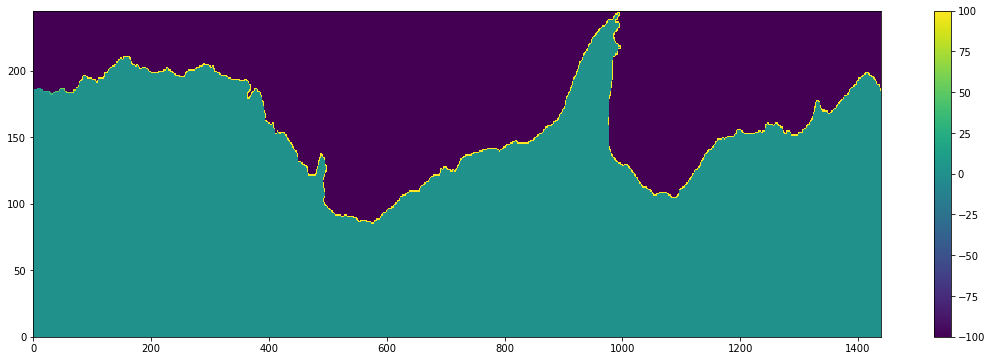

In [43]:
plt.figure(figsize=[19,6])
plt.pcolormesh(contour_masked_above,vmax=100)
plt.colorbar()
plt.show()

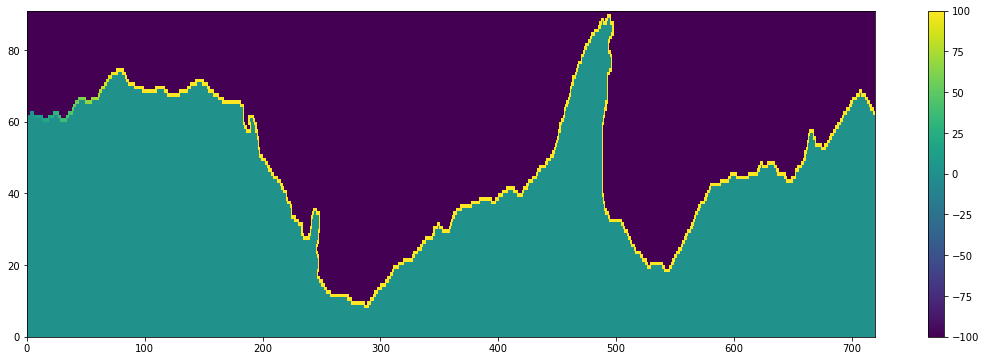

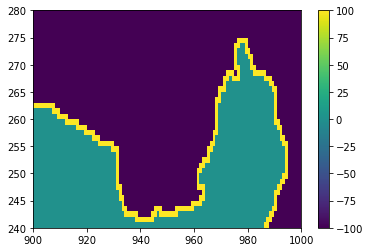

In [56]:
plt.pcolormesh(contour_masked_above,vmax=100)
#plt.xlim([450,500]) #p25
#plt.ylim([80,100]) #p25
plt.xlim([900,1000]) #p125
plt.ylim([240,280]) #p125
plt.colorbar()

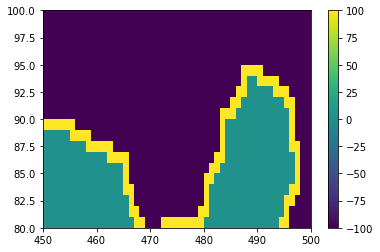

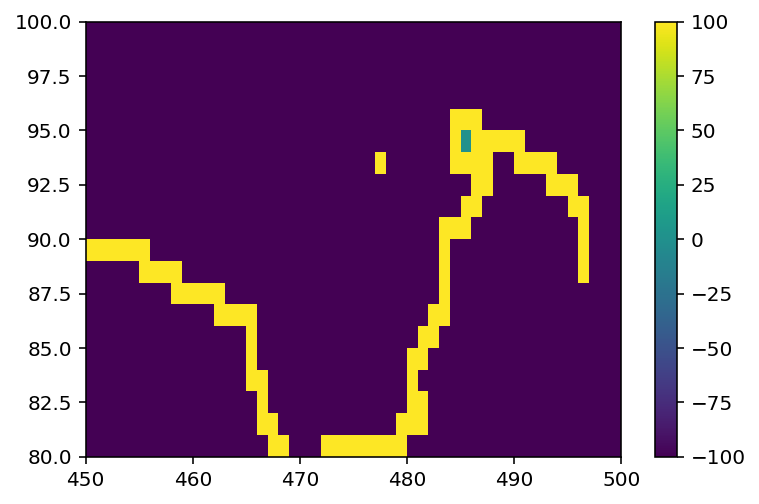

### Create masks for zonal or meridional transport fields
Make masks to multiply x and y transports at correct places. First, separate out points on isobath that will correspond to zonal or meridional transport across contour (i.e. depending on localshape of contour).

In [44]:
# Array of zeros with same shape as contour_mask_numbered
mask_x_transport = np.zeros_like(contour_mask_numbered)

# Array of zeros with same shape as contour_mask_numbered
mask_y_transport = np.zeros_like(contour_mask_numbered)

# Aray of zeros with same shape as contour_mask_numbered
mask_y_transport_numbered = np.zeros_like(contour_mask_numbered)

# Array of zeros with same shape as contour_mask_numbered
mask_x_transport_numbered = np.zeros_like(contour_mask_numbered)

In [45]:
### Create halo array:
# Create new array of zeros with two extra columns along x (p25: 1440 -> 1442)
contour_masked_above_halo = np.zeros((contour_masked_above.shape[0],
                                      contour_masked_above.shape[1]+2))

# First column (first x value) is equal to column of the last x value from contour_masked_above
contour_masked_above_halo[:,0] = contour_masked_above[:,-1]            
contour_masked_above_halo[:,1:-1] = contour_masked_above

# Last column (last x value) is equal to column of the first x value from contour_masked_above
contour_masked_above_halo[:,-1] = contour_masked_above[:,0]

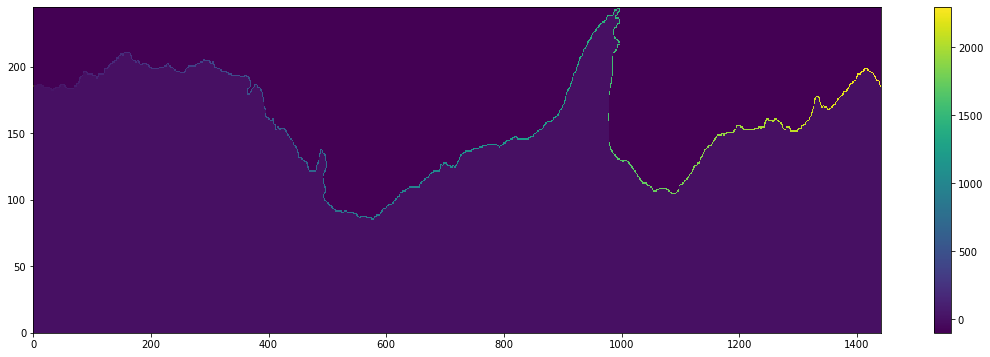

In [46]:
plt.figure(figsize=[19,6])
plt.pcolormesh(contour_masked_above_halo)
plt.colorbar()

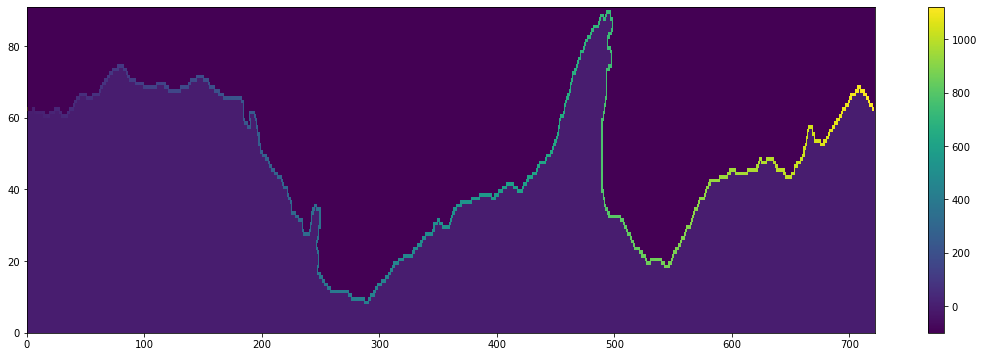

In [47]:
new_number_count = 1
for mask_loc in range(1,int(np.max(contour_mask_numbered))+1):
    
    # Second element of tuple from np.where(contour_mask_numbered==mask_loc)
    index_i = np.where(contour_mask_numbered==mask_loc)[1]
    
    # First element of tuple from np.where(contour_mask_numbered==mask_loc)
    index_j = np.where(contour_mask_numbered==mask_loc)[0]
    
    # if point above is towards Antarctica and point below is away from Antarctica:
    # take transport grid point to north of t grid:
    if (contour_masked_above[index_j+1,index_i]==0) and \
        (contour_masked_above[index_j-1,index_i]!=0):
        
        mask_y_transport[index_j,index_i] = -1
        mask_y_transport_numbered[index_j,index_i] = new_number_count # important to do 
        new_number_count += 1
        
    # if point below is towards Antarctica and point above is away from Antarctica:
    # take transport grid point to south of t grid:
    elif (contour_masked_above[index_j-1,index_i]==0) and \
        (contour_masked_above[index_j+1,index_i]!=0):
        
        mask_y_transport[index_j-1,index_i] = 1
        mask_y_transport_numbered[index_j-1,index_i] = new_number_count
        new_number_count += 1
        
    # If point to right is towards Antarctica and point to left is away from Antarctica:
    # Zonal indices increased by 1 due to halos
    # Take transport grid point on right of t grid:
    if (contour_masked_above_halo[index_j,index_i+2]==0) and \
        (contour_masked_above_halo[index_j,index_i]!=0):
        mask_x_transport[index_j,index_i] = -1
        mask_x_transport_numbered[index_j,index_i] = new_number_count
        new_number_count += 1
        
    # If point to left is towards Antarctica and point to right is away from Antarctica:
    # Take transport grid point on left of t grid:
    elif (contour_masked_above_halo[index_j,index_i]==0) and \
        (contour_masked_above_halo[index_j,index_i+2]!=0):
        mask_x_transport[index_j,index_i-1] = 1
        mask_x_transport_numbered[index_j,index_i-1] = new_number_count
        new_number_count += 1

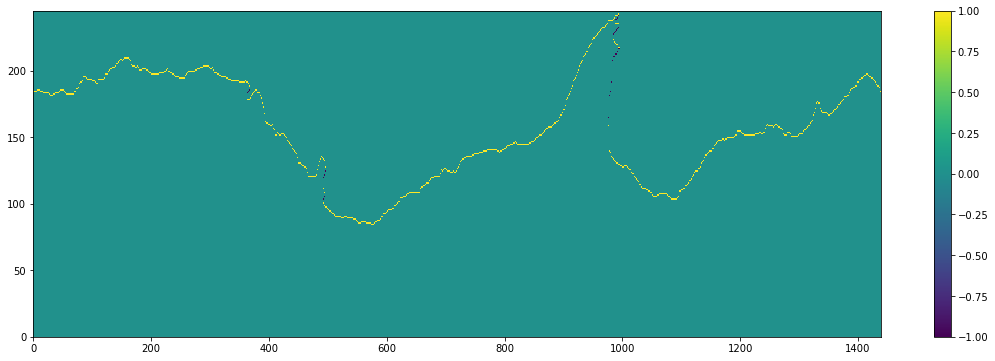

In [48]:
plt.figure(figsize=[19,6])
plt.pcolormesh(mask_y_transport)
plt.colorbar()
plt.show()

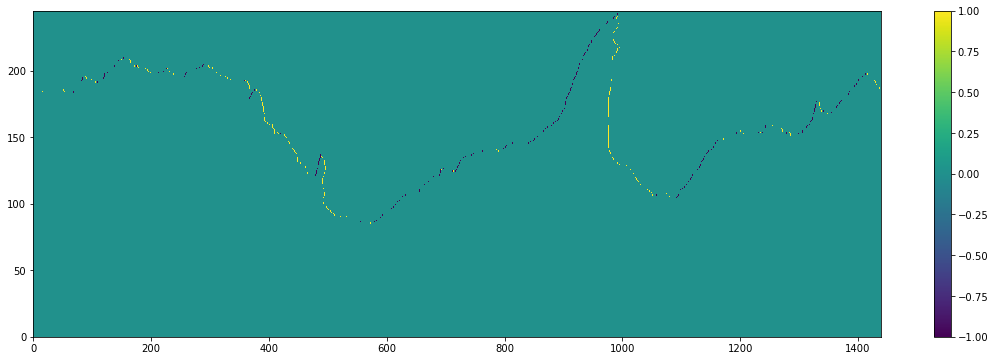

In [49]:
plt.figure(figsize=[19,6])
plt.pcolormesh(mask_x_transport)
plt.colorbar()
plt.show()

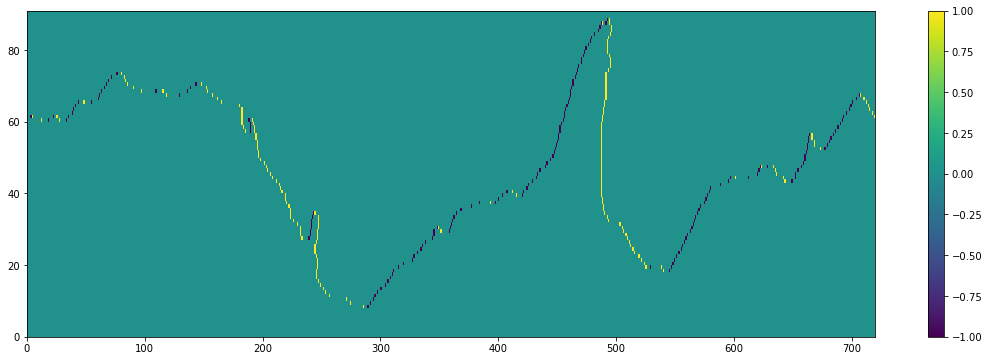

### Save the arrays created here as xarray dataset

**IMPORTANT**:
- The code to create the 1000 m isobath contour puts the `masked_y_transport` and `masked_x_transport` at the correct locations relative to the T cell for the `umo` and `vmo` points. No interpolation should be performed!
- The dimensions of the masks are in on the tracer grid (`xh`, `yh`). So we need get them in the correct dimensions to allow multiplication of `umo*masked_x_transport`, `vmo*masked_y_transport`.

In [50]:
# The masks are numpy arrays, so first we need to transform them into xarray Data Arrays.
mask_y_transport = xr.DataArray(mask_y_transport,dims = ['yh','xh'])
mask_x_transport = xr.DataArray(mask_x_transport,dims = ['yh','xh'])

mask_y_transport_numbered = xr.DataArray(mask_y_transport_numbered,dims = ['yh','xh'])
mask_x_transport_numbered = xr.DataArray(mask_x_transport_numbered,dims = ['yh','xh'])

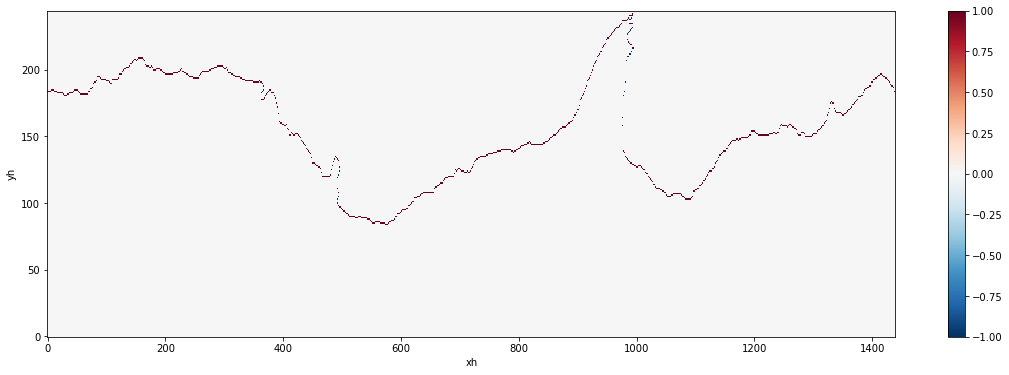

In [51]:
mask_y_transport.plot(figsize=[19,6])

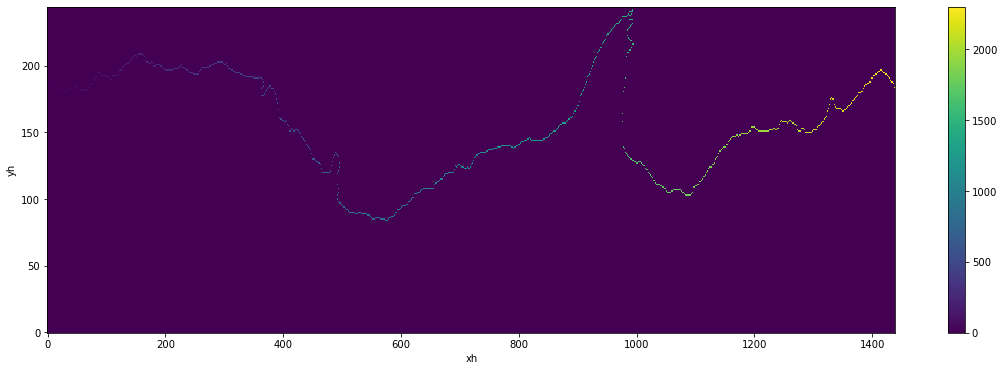

In [52]:
mask_y_transport_numbered.plot(figsize=[19,6])

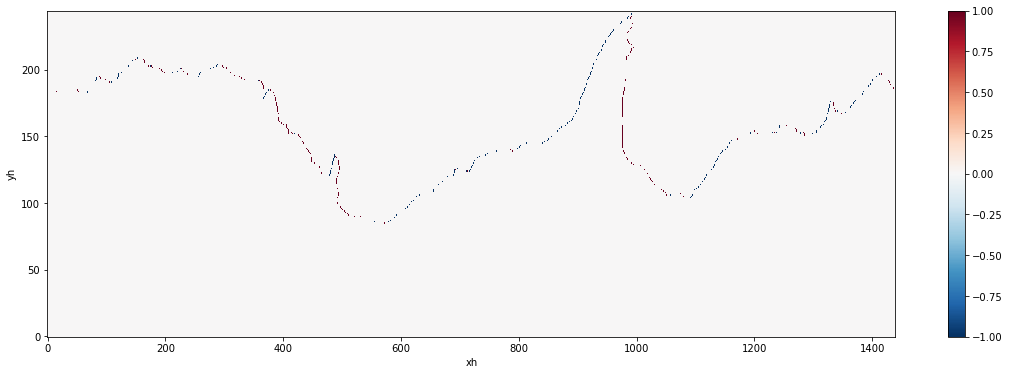

In [53]:
mask_x_transport.plot(figsize=[19,6])

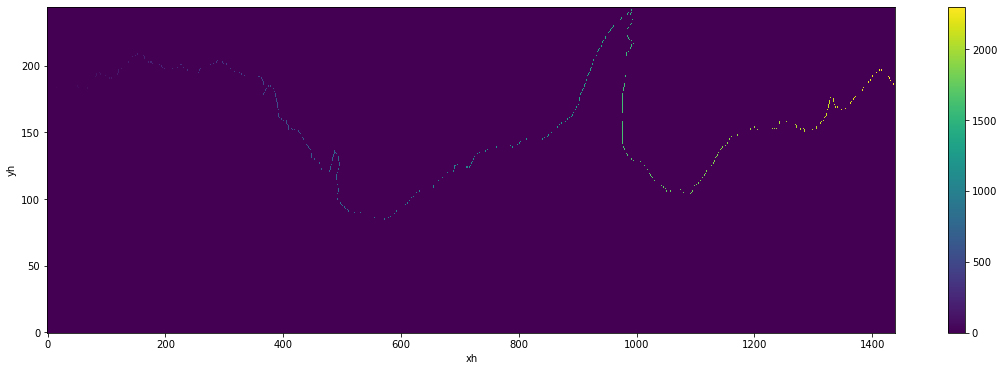

In [54]:
mask_x_transport_numbered.plot(figsize=[19,6])

In [56]:
# This is a hack to ensure all indecies (including xq an yq) are assigned.
# Use the existing grid dataset and add the trasnport masks

if pp.split('_')[-1]=='d2':
    n_y = 245 if grid_res=='p125' else 245
else:
    n_y = 490 if grid_res=='p125' else 202 if grid_res=='p25' else 91

In [58]:
grid_ext = grid.isel(yh=slice(0,n_y),yq=slice(0,n_y)).load()

In [59]:
grid_ext['mask_for_umo_transports']=xr.DataArray(mask_x_transport.values,dims=('yh','xq'))
grid_ext['mask_for_vmo_transports']=xr.DataArray(mask_y_transport.values,dims=('yq','xh'))
grid_ext['mask_for_umo_transports_numbered']=xr.DataArray(mask_x_transport_numbered.values,dims=('yh','xq'))
grid_ext['mask_for_vmo_transports_numbered']=xr.DataArray(mask_y_transport_numbered.values,dims=('yq','xh'))

In [60]:
contour_mask_numbered = xr.DataArray(contour_mask_numbered, coords = [yh, xh], dims = ['yh', 'xh'])
contour_mask_numbered.attrs['description'] =\
    '(OM4) Continous circumpolar approximation of the near Antarctic 1000 m isobath.'\
    +' Points on the isobath (tracer points) are numbered sequentially, providing an along-isobath index.'

contour_masked_south = xr.DataArray(contour_masked_above, coords = [yh, xh], dims = ['yh', 'xh'])
contour_masked_south = contour_masked_south.where(contour_masked_south >= 0) * 0 + 1 
contour_masked_south.attrs['description'] =\
    '(OM4) Masks for the region south of a continous circumpolar approximation '\
    +'of the near Antarctic 1000 m isobath. Tracer points on and polewards of the isobath are 1,'\
    +' points equatorward of the isobath are nan.'

In [61]:
mask_for_vmo_transports = xr.DataArray(grid_ext.mask_for_vmo_transports,dims = ['yq','xh'])
mask_for_vmo_transports.attrs['description'] =\
    '(OM4) Informs which sign of v (meridional transport) is transport *into* the 1000 m isobath enclosed region.'+\
    ' This mask is -1 where positive v denotes transport poleward across the isobath and +1 where positive v '+\
    'denotes tranport equatorward across the isobath. '+\
    '0 where isobath not present, or cross isobath transport is zonal (see mask_for_umo_transport). '+\
    'When using this mask, positive cross-isobath transports are offshore.'

mask_for_umo_transports = xr.DataArray(grid_ext.mask_for_umo_transports,dims = ['yh','xq'])
mask_for_umo_transports.attrs['description'] = '(OM4) Informs which sign of u (zonal transport) is transport '+\
    '*into* the 1000 m isobath enclosed region. This mask is -1 where positive u denotes transport poleward '+\
    'across the isobath and +1 where positive u denotes tranport equatorward across the isobath. '+\
    '0 where isobath not present, or cross isobath transport is meridional (see mask_for_vmo_transport). '+\
    'When using this mask, positive cross-isobath transports are offshore.'

In [62]:
mask_for_vmo_transports_numbered = xr.DataArray(grid_ext.mask_for_vmo_transports_numbered,dims = ['yq','xh'])
mask_for_vmo_transports_numbered.attrs['description'] = \
    '(OM4) as contour_mask_numbered, except only points on the isobath running east-west '+\
    '(for which cross-isobath transport is meridional transport) included.'

mask_for_umo_transports_numbered = xr.DataArray(grid_ext.mask_for_umo_transports_numbered,dims = ['yh','xq'])
mask_for_umo_transports_numbered.attrs['description'] = \
    '(OM4) as contour_mask_numbered, except only points on the isobath running north-south '+\
    '(for which cross-isobath transport is zonal transport) included.'

In [63]:
# assigning geolat / geolon coords here (only necessary for plotting)
contour_mask_numbered.coords['geolon'] = geolon
contour_mask_numbered.coords['geolat'] = geolat
contour_masked_south.coords['geolon'] = geolon
contour_masked_south.coords['geolat'] = geolat

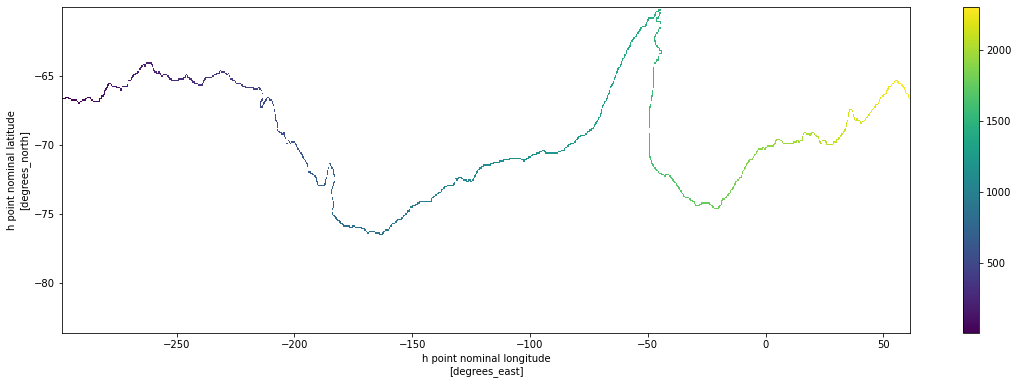

In [64]:
contour_mask_numbered.where(contour_mask_numbered>0).plot(figsize=[19,6])

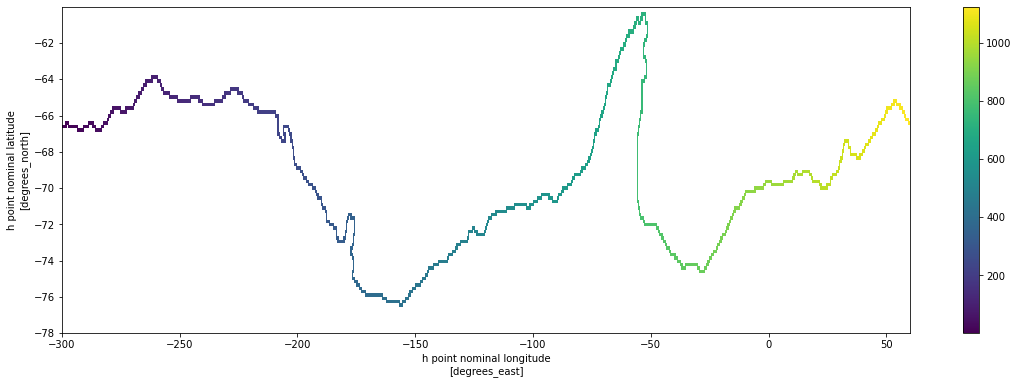

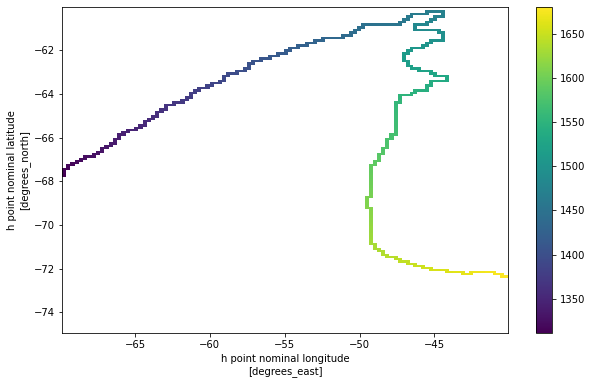

In [65]:
contour_mask_numbered.where(contour_mask_numbered>0).sel(xh=slice(-70,-40),yh=slice(-75,-60)).plot(figsize=[10,6])

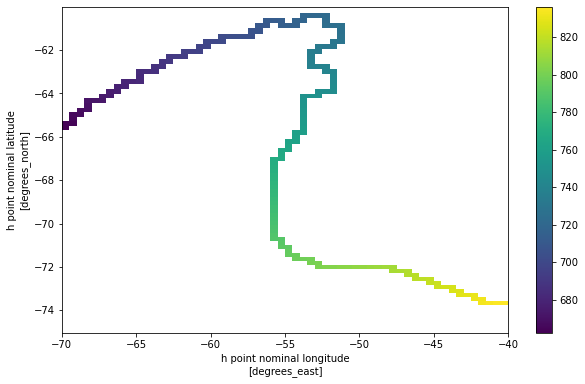

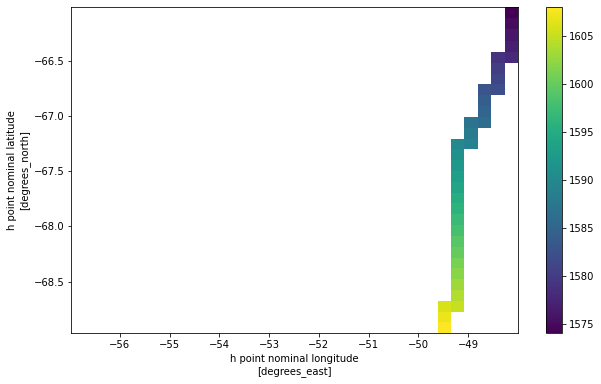

In [66]:
contour_mask_numbered.where(contour_mask_numbered>0).sel(xh=slice(-57,-48),yh=slice(-69,-66)).plot(figsize=[10,6])

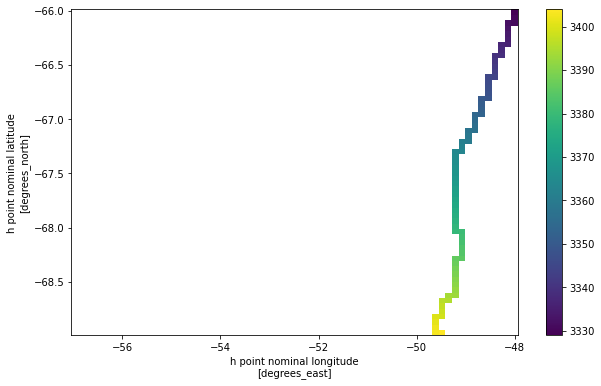

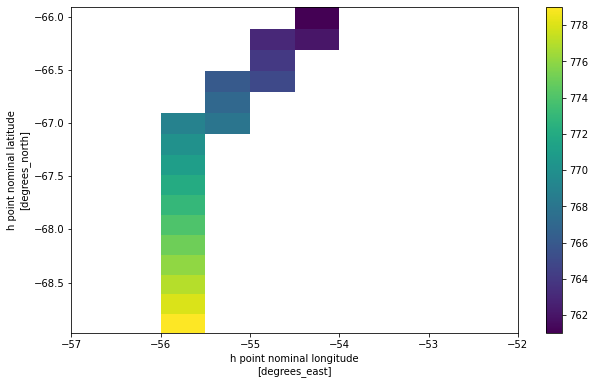

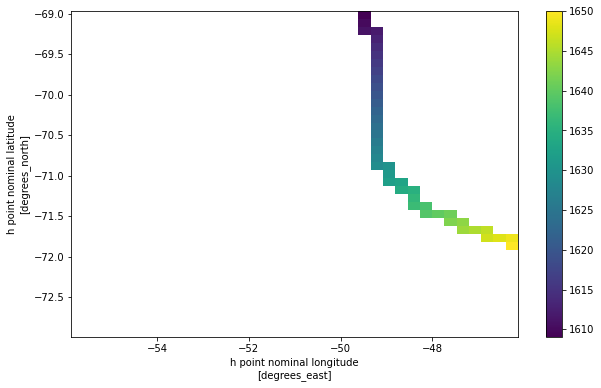

In [67]:
contour_mask_numbered.where(contour_mask_numbered>0).sel(xh=slice(-56,-46),yh=slice(-73,-69)).plot(figsize=[10,6])

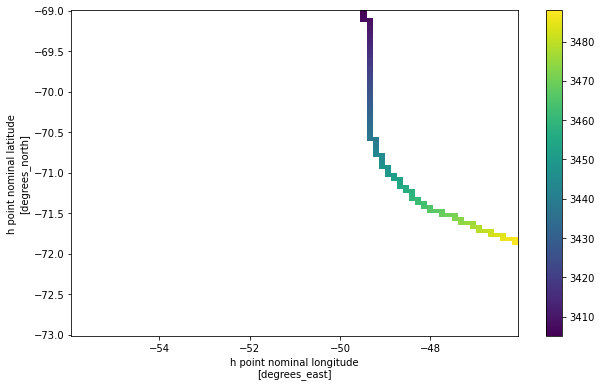

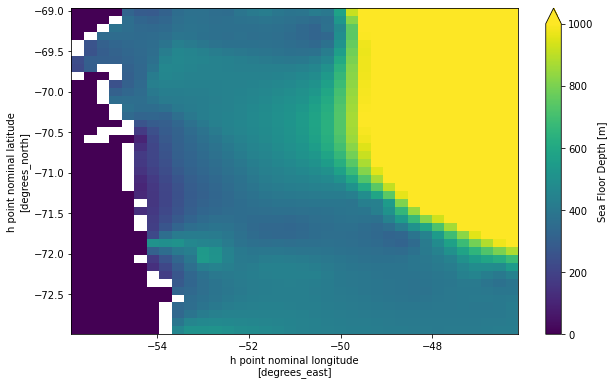

In [68]:
grid_ext.deptho.sel(xh=slice(-56,-46),yh=slice(-73,-69)).plot(figsize=[10,6],vmax=1000)

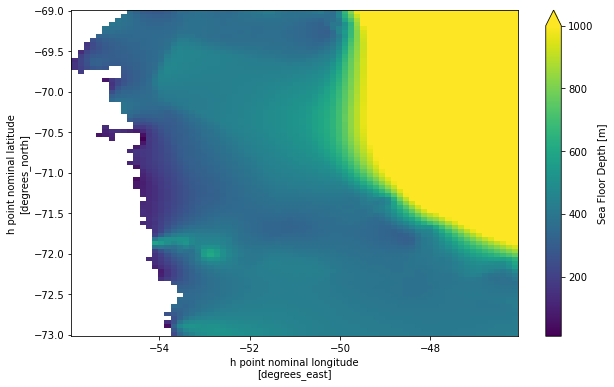

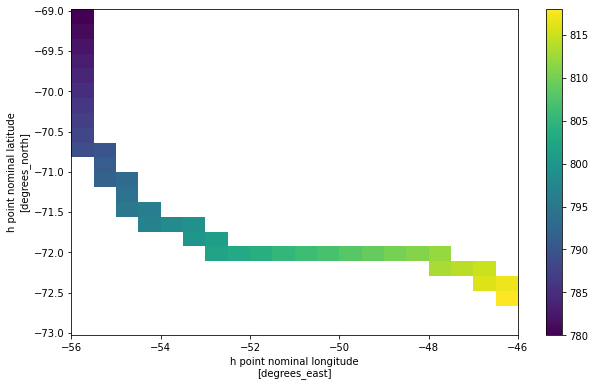

## Save the created data arrays as a dataset:


In [69]:
ds_all_arrays = xr.Dataset({'contour_mask_numbered':contour_mask_numbered, 
                            'contour_masked_south':contour_masked_south, 
                            'mask_for_vmo_transports':mask_for_vmo_transports, 
                            'mask_for_umo_transports':mask_for_umo_transports,
                            'mask_for_vmo_transports_numbered':mask_for_vmo_transports_numbered,
                            'mask_for_umo_transports_numbered':mask_for_umo_transports_numbered})

In [70]:
ds_all_arrays

<xarray.Dataset>
Dimensions:                           (yh: 245, xh: 1440, yq: 245, xq: 1440)
Coordinates:
  * yh                                (yh) float64 -83.62 -83.54 ... -60.08
  * xh                                (xh) float64 -298.6 -298.4 ... 60.93 61.16
    geolon                            (yh, xh) float32 -298.5 -298.2 ... 60.0
    geolat                            (yh, xh) float32 -82.4 -82.4 ... -59.99
  * yq                                (yq) float64 -83.56 -83.48 ... -59.99
  * xq                                (xq) float64 -298.4 -298.2 ... 61.12 61.35
Data variables:
    contour_mask_numbered             (yh, xh) float64 0.0 0.0 0.0 ... 0.0 0.0
    contour_masked_south              (yh, xh) float64 1.0 1.0 1.0 ... nan nan
    mask_for_vmo_transports           (yq, xh) float64 0.0 0.0 0.0 ... 0.0 0.0
    mask_for_umo_transports           (yh, xq) float64 0.0 0.0 0.0 ... 0.0 0.0
    mask_for_vmo_transports_numbered  (yq, xh) float64 0.0 0.0 0.0 ... 0.0 0.0
    mask_for_umo_transports_numbered  (yh, xq) float64 0.0 0.0 0.0 ... 0.0 0.0

In [13]:
### Save dataset to netcdf file:
fname = rootdir+grid_res+'%s'%('_d2' if pp.split('_')[-1]=='d2' else '')\
        +'_1000m_Isobath_Contour_Transport_Masks.nc'
print('Saving file:\n',fname)
ds_all_arrays.to_netcdf(fname)

Saving file:
 /work/jet/static/p125_d2_d2_1000m_Isobath_Contour_Transport_Masks.nc


### Map masks with projection (cartopy)

In [74]:
import cartopy
import matplotlib.path as mpath
import cmocean.cm as cmo

In [75]:
theta = np.linspace(0, 2*np.pi, 100)
center, radius = [0.5, 0.5], 0.5
verts = np.vstack([np.sin(theta), np.cos(theta)]).T
circle = mpath.Path(verts * radius + center)

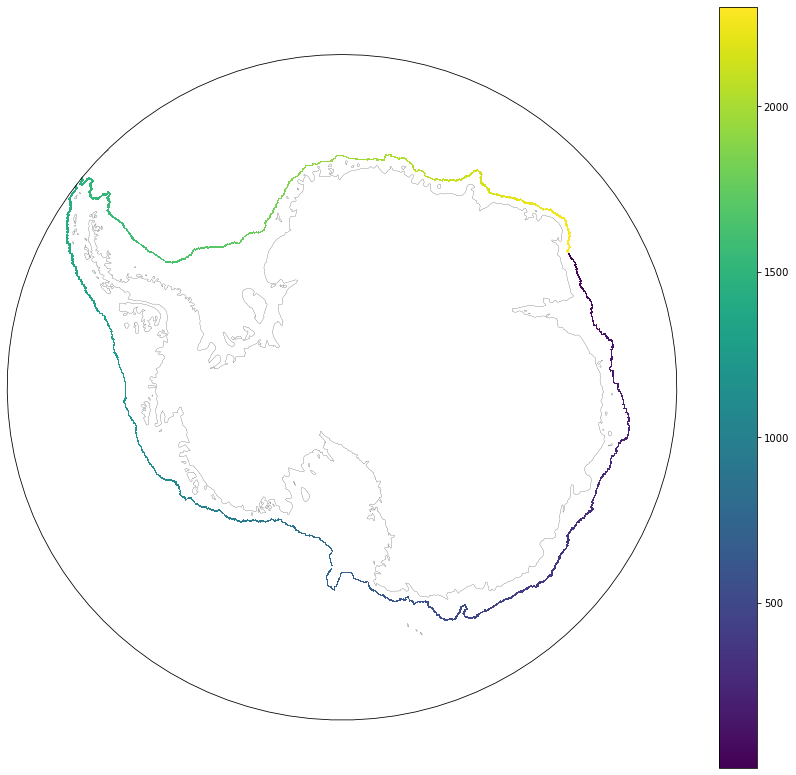

In [77]:
fig = plt.figure(figsize=[15, 14])
ax = plt.axes(projection=cartopy.crs.SouthPolarStereo())
ax.coastlines(lw=0.2)
ax.set_extent([-180,180,-90,-60], cartopy.crs.PlateCarree())
ax.set_boundary(circle,transform=ax.transAxes)
p = contour_mask_numbered.where(contour_mask_numbered>0).plot(x='geolon',y='geolat',shading='auto',
                                                              transform=cartopy.crs.PlateCarree())

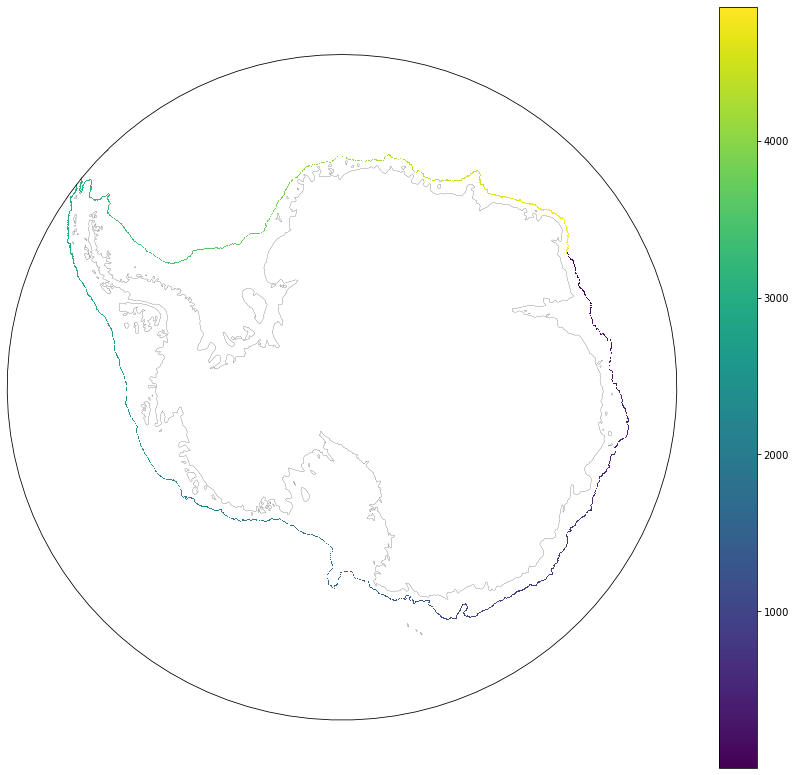

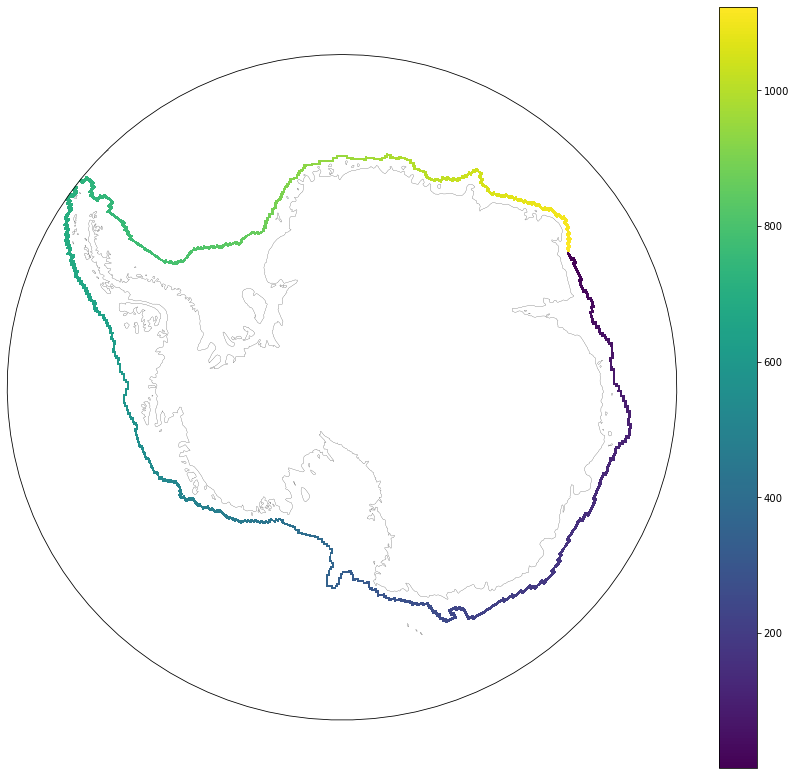

#### Investigate the isobath masks to make sure all points are accounted for and region is fully enclosed

In [78]:
# Check contour_mask_numbered
# When I look at this it looks like there are several regions, one being along the isobath
# In the western Weddell Where there are double points?

contour_mask_numbered_1D = contour_mask_numbered.stack(contour_position = ['yh','xh'])
contour_mask_numbered_1D = contour_mask_numbered_1D.where(contour_mask_numbered_1D>0,drop=True)

contour_index = contour_mask_numbered_1D.sortby(contour_mask_numbered_1D)
lat_along_contour = contour_index.yh
lon_along_contour = contour_index.xh

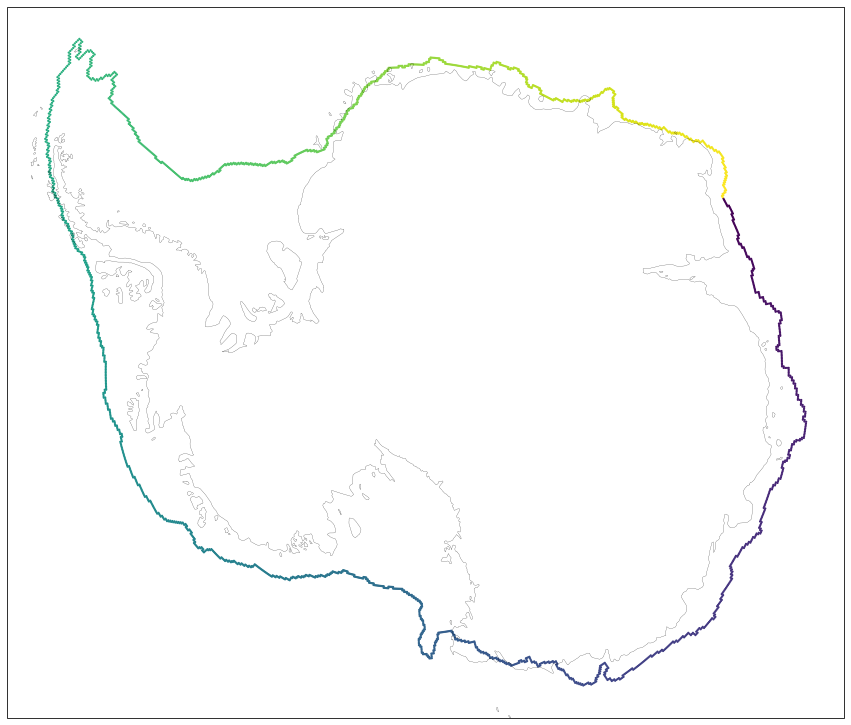

In [79]:
fig = plt.figure(figsize=[15, 14])
ax = plt.axes(projection=cartopy.crs.Stereographic(central_longitude=0,central_latitude=-90))
ax.coastlines(lw=0.2)
p = ax.scatter(lon_along_contour, lat_along_contour, c=contour_index, transform = cartopy.crs.PlateCarree(), s=1.5)

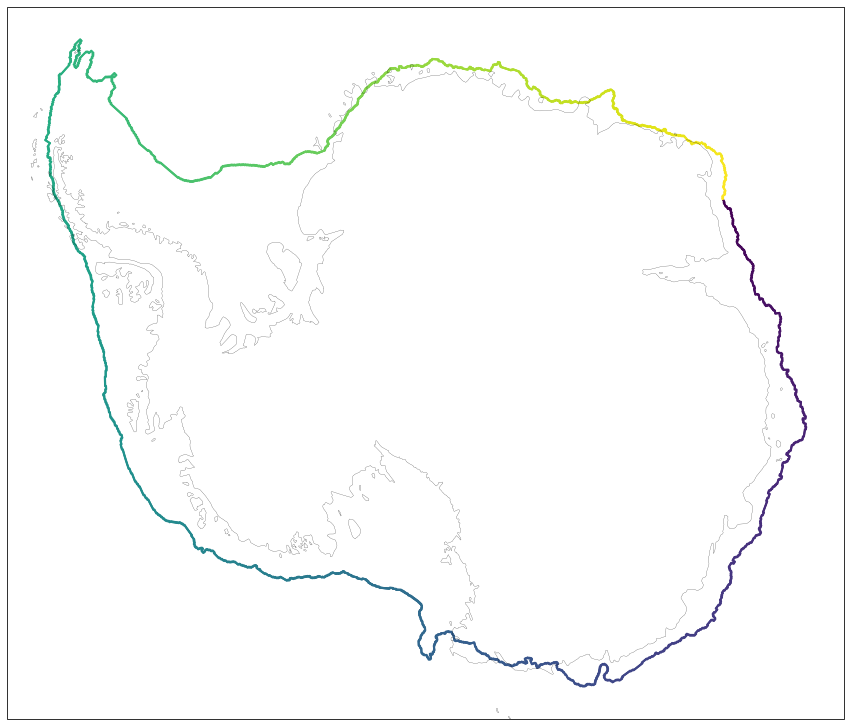

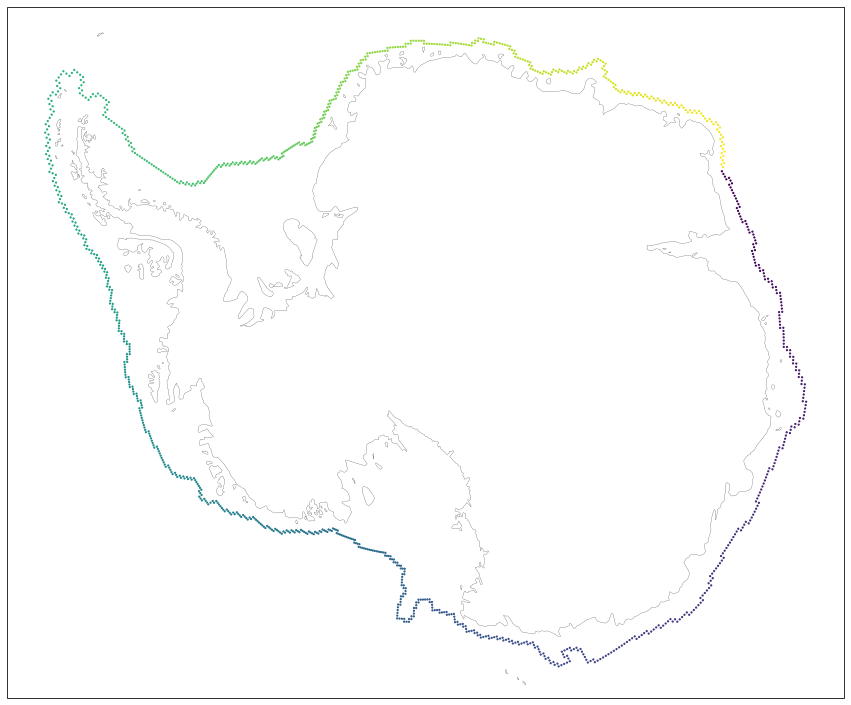

### Compare to previous version

In [78]:
#ds_rlb = xr.open_dataset(rootdir[:-7]+'rlb_masks/CM4_1000m_Isobath_Contour_Transport_Masks.nc')
ds_rlb = xr.open_dataset(rootdir[:-7]+'rlb_masks/ESM4_1000m_Isobath_Contour_Transport_Masks.nc')

In [98]:
def along_contour(ds):
    contour_mask_numbered_1D = ds.contour_mask_numbered.stack(contour_position = ['yh','xh'])
    contour_mask_numbered_1D = contour_mask_numbered_1D.where(contour_mask_numbered_1D>0,drop=True)
    contour_index = contour_mask_numbered_1D.sortby(contour_mask_numbered_1D)
    lat_along_contour = contour_index.yh
    lon_along_contour = contour_index.xh
    
    return lon_along_contour, lat_along_contour, contour_index

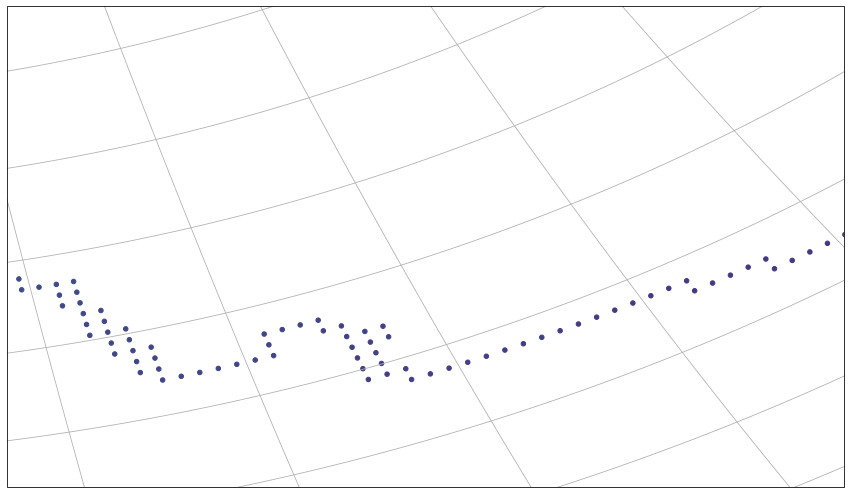

In [80]:
fig = plt.figure(figsize=[15, 10])
ax = plt.subplot(projection = cartopy.crs.Orthographic(-10, -60))
ax.gridlines()
plot = ax.scatter(along_contour(ds_rlb)[0],along_contour(ds_rlb)[1],c=along_contour(ds_rlb)[2],
                  transform = cartopy.crs.PlateCarree(),s=20)
ax.set_extent([-220, -200, -65, -70], cartopy.crs.PlateCarree())

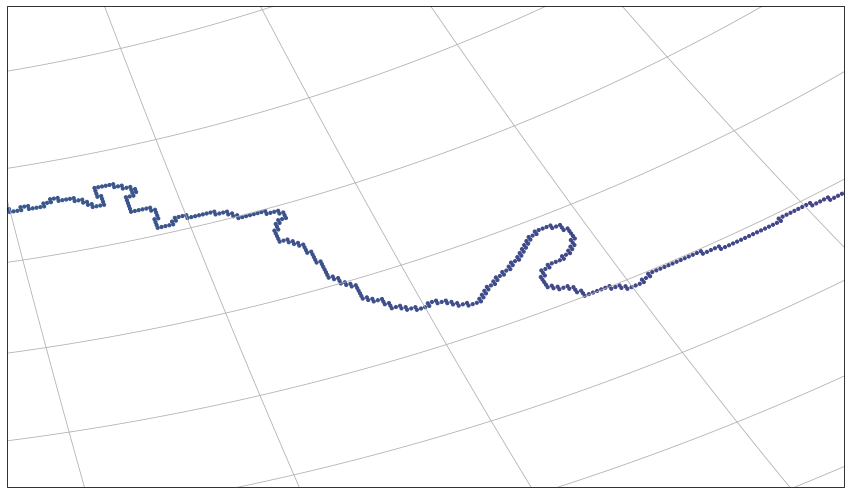

In [100]:
fig = plt.figure(figsize=[15, 10])
ax = plt.subplot(projection = cartopy.crs.Orthographic(-10, -60))
ax.gridlines()
plot = ax.scatter(along_contour(ds_all_arrays)[0],along_contour(ds_all_arrays)[1],c=along_contour(ds_all_arrays)[2],
                  transform = cartopy.crs.PlateCarree(),s=10)
ax.set_extent([-220, -200, -65, -70], cartopy.crs.PlateCarree())

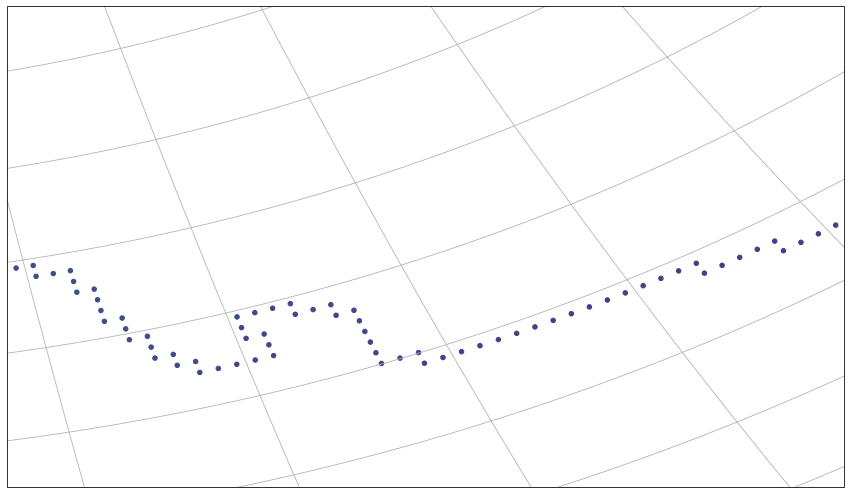

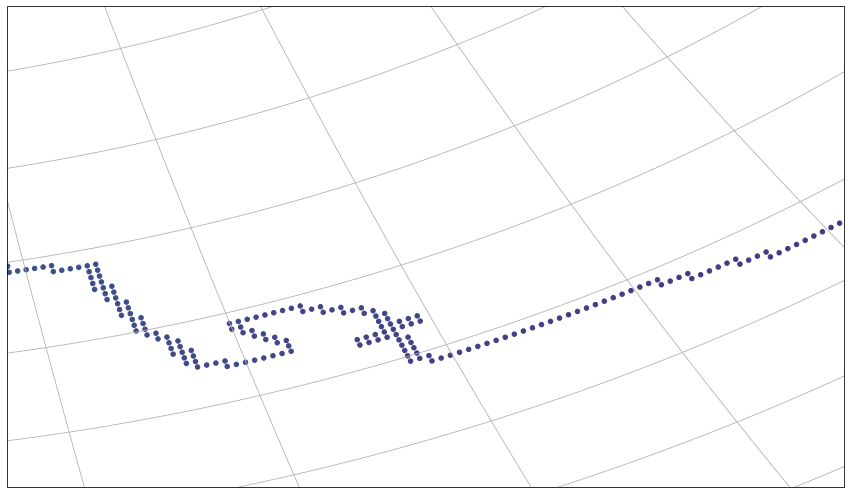

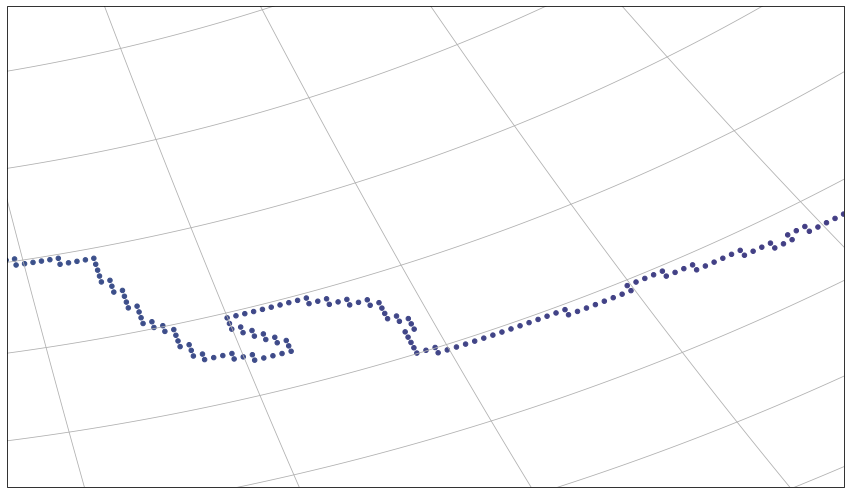

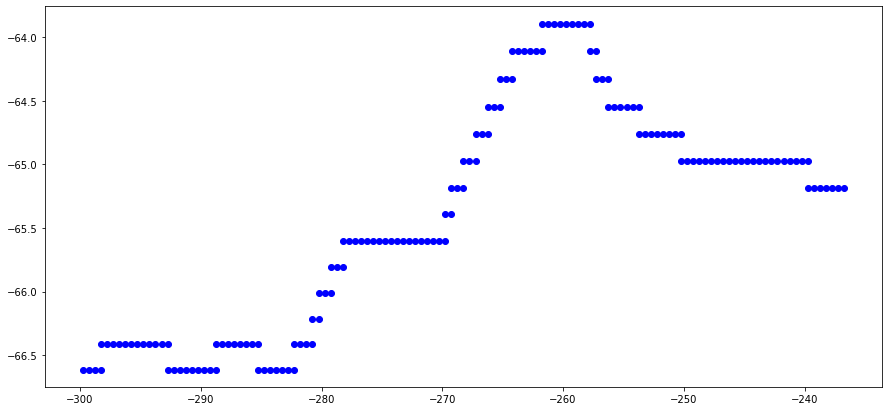

In [82]:
fig = plt.figure(figsize=[15, 7])
ax = plt.subplot()
plot = ax.plot(along_contour(ds_rlb)[2].xh[:150],along_contour(ds_rlb)[2].yh[:150],'bo')

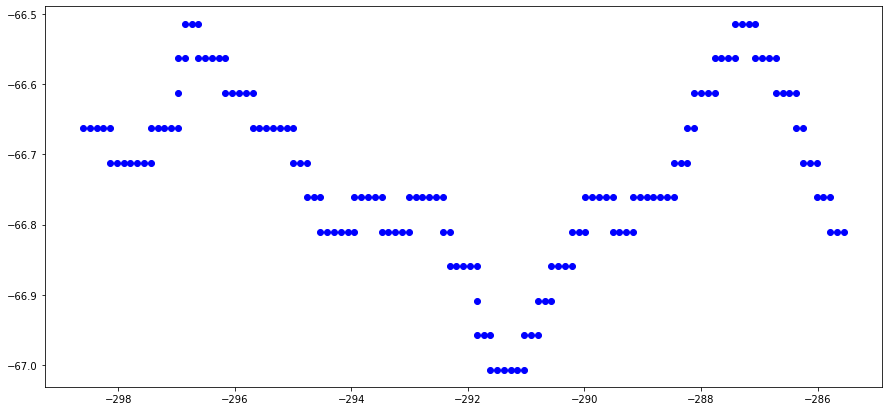

In [101]:
fig = plt.figure(figsize=[15, 7])
ax = plt.subplot()
plot = ax.plot(along_contour(ds_all_arrays)[2].xh[:150],along_contour(ds_all_arrays)[2].yh[:150],'bo')

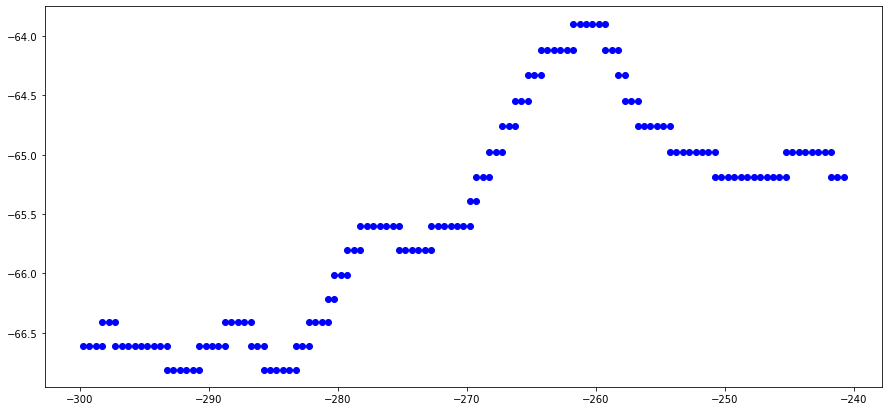

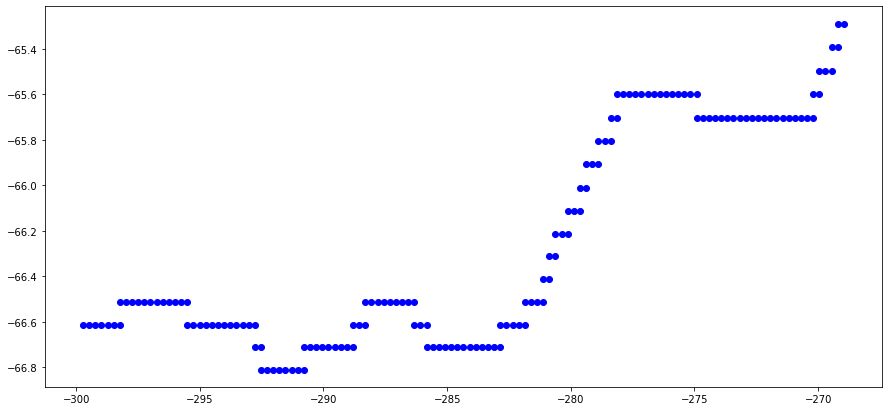

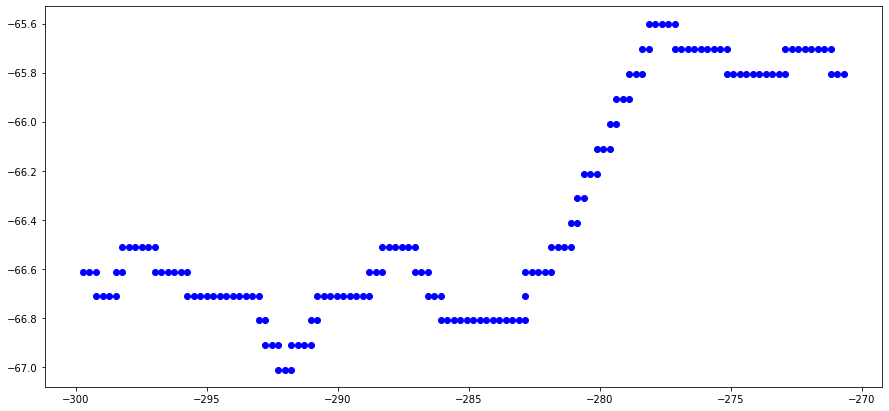

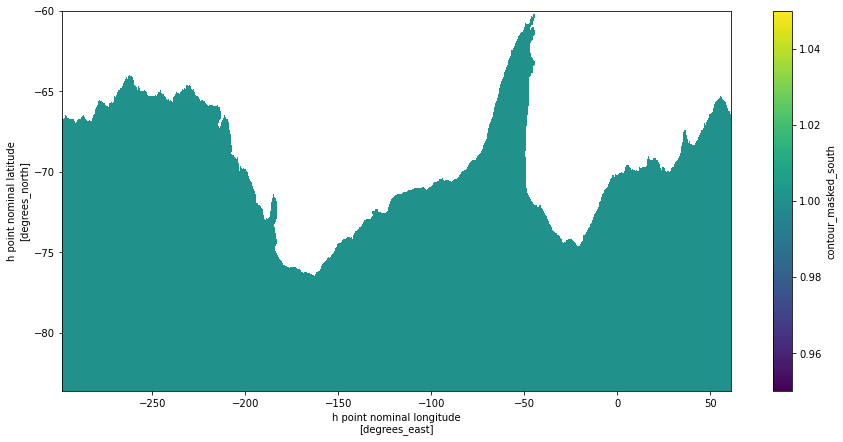

In [102]:
ds_all_arrays.contour_masked_south.plot(figsize=[15, 7])

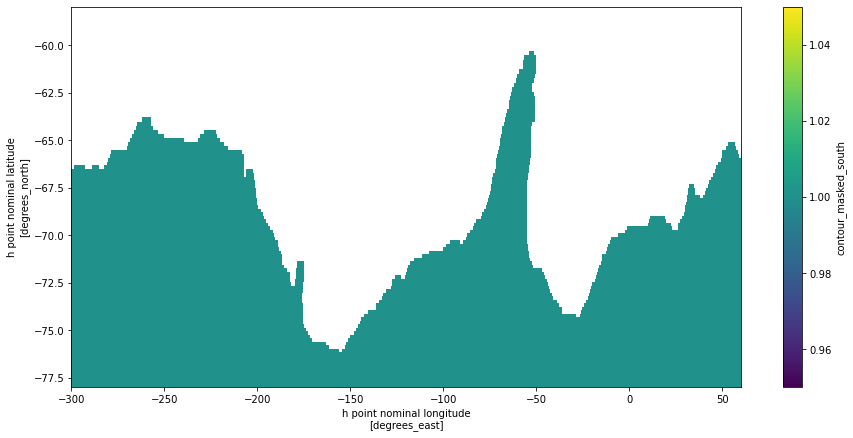

In [85]:
ds_rlb.contour_masked_south.plot(figsize=[15, 7])

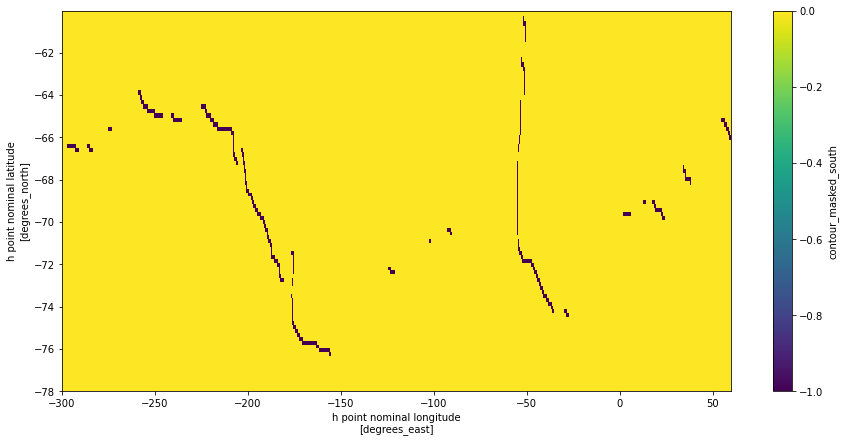

In [86]:
fig = plt.figure(figsize=[15, 7])
#diff = ds_all_arrays.contour_masked_south.fillna(0)-ds_rlb.contour_masked_south.fillna(0)
#diff.where(diff!=0).plot()
(ds_all_arrays.contour_masked_south.fillna(0)-ds_rlb.contour_masked_south.fillna(0)).plot()

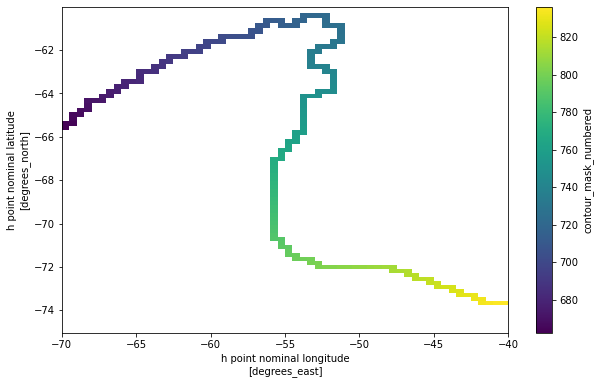

In [87]:
ds_all_arrays.contour_mask_numbered.where(ds_all_arrays.contour_mask_numbered>0)\
    .sel(xh=slice(-70,-40),yh=slice(-75,-60)).plot(figsize=[10,6])

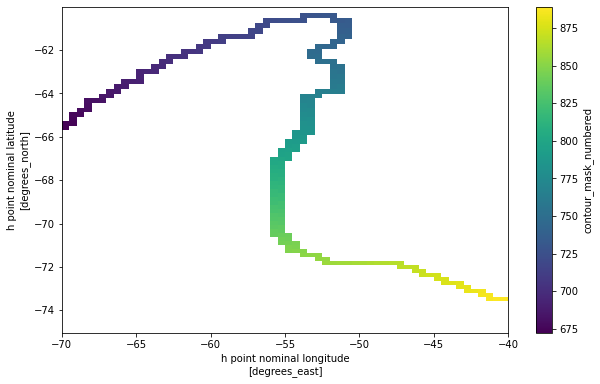

In [88]:
ds_rlb.contour_mask_numbered.where(ds_rlb.contour_mask_numbered>0)\
    .sel(xh=slice(-70,-40),yh=slice(-75,-60)).plot(figsize=[10,6])

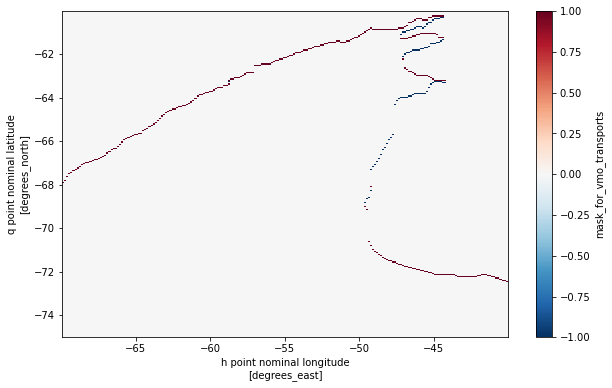

In [103]:
ds_all_arrays.mask_for_vmo_transports.sel(xh=slice(-70,-40),yq=slice(-75,-60)).plot(figsize=[10,6])

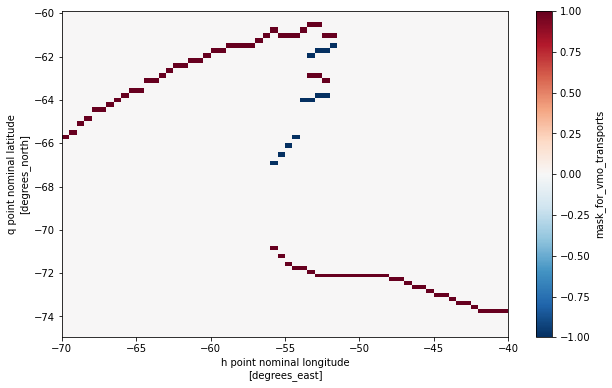

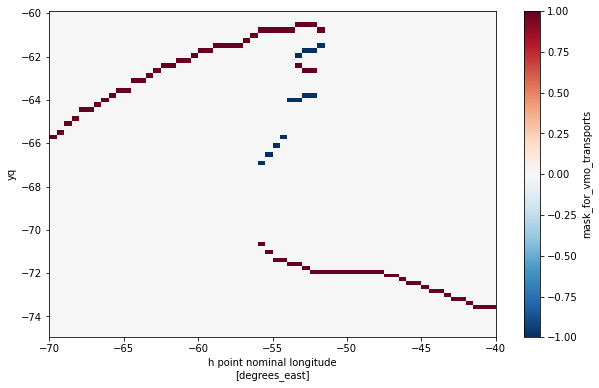

In [90]:
ds_rlb.mask_for_vmo_transports.sel(xh=slice(-70,-40),yq=slice(-75,-60)).plot(figsize=[10,6])

In [91]:
ds_all_arrays.mask_for_vmo_transports.description

'(OM4) Informs which sign of v (meridional transport) is transport *into* the 1000 m isobath enclosed region. This mask is -1 where positive v denotes transport poleward across the isobath and +1 where positive v denotes tranport equatorward across the isobath. 0 where isobath not present, or cross isobath transport is zonal (see mask_for_umo_transport). When using this mask, positive cross-isobath transports are offshore.'

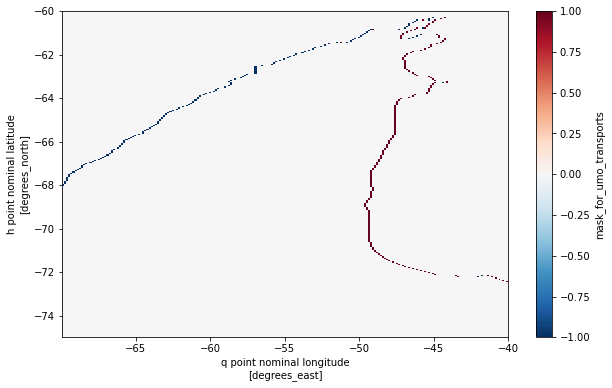

In [104]:
ds_all_arrays.mask_for_umo_transports.sel(xq=slice(-70,-40),yh=slice(-75,-60)).plot(figsize=[10,6])

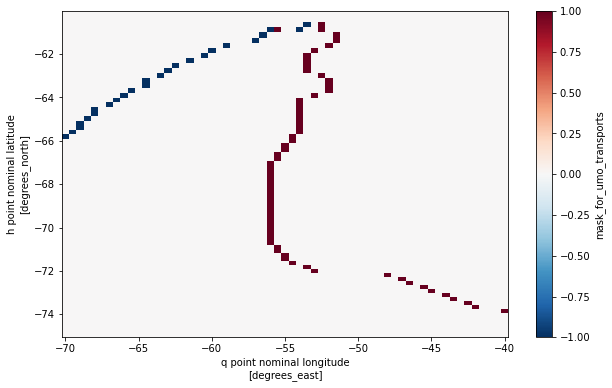

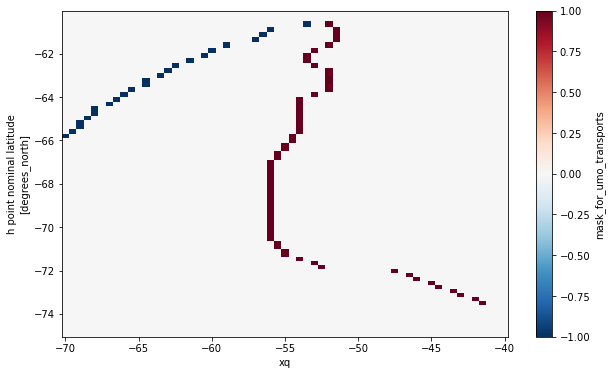

In [93]:
ds_rlb.mask_for_umo_transports.sel(xq=slice(-70,-40),yh=slice(-75,-60)).plot(figsize=[10,6])

In [94]:
ds_all_arrays.mask_for_umo_transports.description

'(OM4) Informs which sign of u (zonal transport) is transport *into* the 1000 m isobath enclosed region. This mask is -1 where positive u denotes transport poleward across the isobath and +1 where positive u denotes tranport equatorward across the isobath. 0 where isobath not present, or cross isobath transport is meridional (see mask_for_vmo_transport). When using this mask, positive cross-isobath transports are offshore.'

### Compare the difference masks (T,U,V)

In [80]:
contour_mask_numbered_1D = ds_all_arrays.contour_mask_numbered.stack(contour_position = ['yh','xh'])
geolon_1D = ds_all_arrays.geolon.stack(contour_position = ['yh','xh'])
geolat_1D = ds_all_arrays.geolat.stack(contour_position = ['yh','xh'])

geolon_1D = geolon_1D.where(contour_mask_numbered_1D>0,drop=True)
geolat_1D = geolat_1D.where(contour_mask_numbered_1D>0,drop=True)
contour_mask_numbered_1D = contour_mask_numbered_1D.where(contour_mask_numbered_1D>0,drop=True)
contour_index = contour_mask_numbered_1D.sortby(contour_mask_numbered_1D)
geolon_index = geolon_1D.sortby(contour_mask_numbered_1D)
geolat_index = geolat_1D.sortby(contour_mask_numbered_1D)

In [81]:
vmo_mask_1D = ds_all_arrays.mask_for_vmo_transports.stack(contour_position = ['yq','xh'])
geolon_v_1D = grid_ext.geolon_v.stack(contour_position = ['yq','xh'])
geolat_v_1D = grid_ext.geolat_v.stack(contour_position = ['yq','xh'])

geolon_v_1D = geolon_v_1D.where(vmo_mask_1D!=0,drop=True)
geolat_v_1D = geolat_v_1D.where(vmo_mask_1D!=0,drop=True)
vmo_mask_1D = vmo_mask_1D.where(vmo_mask_1D!=0,drop=True)

In [82]:
umo_mask_1D = ds_all_arrays.mask_for_umo_transports.stack(contour_position = ['yh','xq'])
geolon_u_1D = grid_ext.geolon_u.stack(contour_position = ['yh','xq'])
geolat_u_1D = grid_ext.geolat_u.stack(contour_position = ['yh','xq'])

geolon_u_1D = geolon_u_1D.where(umo_mask_1D!=0,drop=True)
geolat_u_1D = geolat_u_1D.where(umo_mask_1D!=0,drop=True)
umo_mask_1D = umo_mask_1D.where(umo_mask_1D!=0,drop=True)

In [83]:
shelf_bathy = grid_ext.deptho.where(ds_all_arrays.contour_masked_south==1)

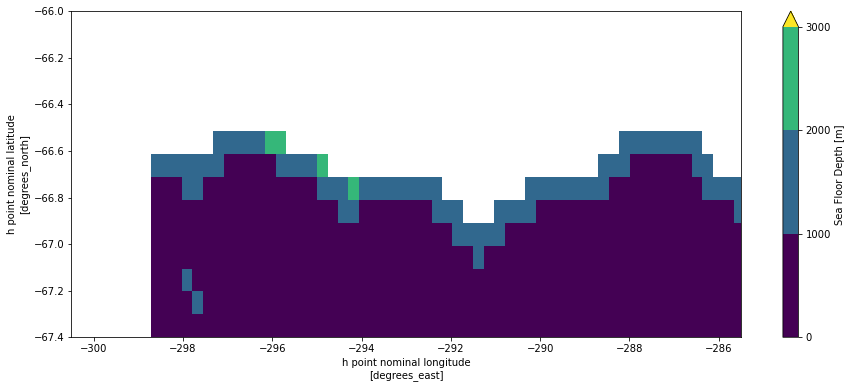

In [84]:
fig, ax = plt.subplots(figsize=(15,6))
shelf_bathy.plot(vmin=0,vmax=3000,levels=4)
ax.set_xlim([-300.5,-285.5])
ax.set_ylim([-67.4,-66])
plt.show()

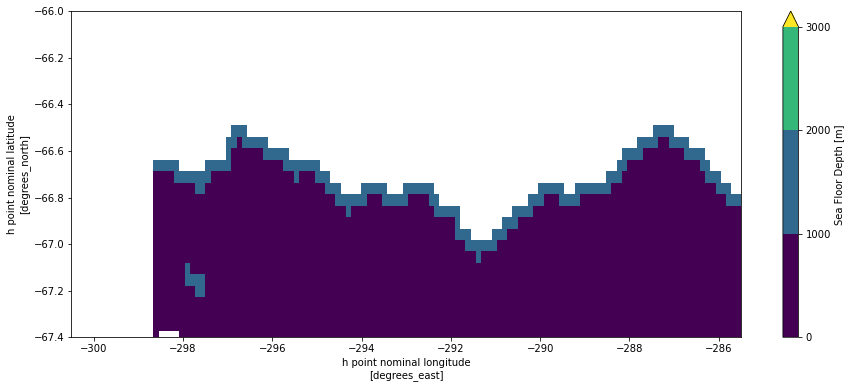

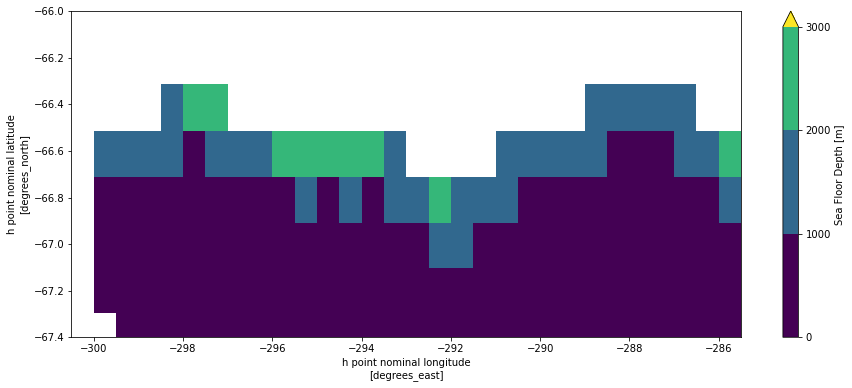

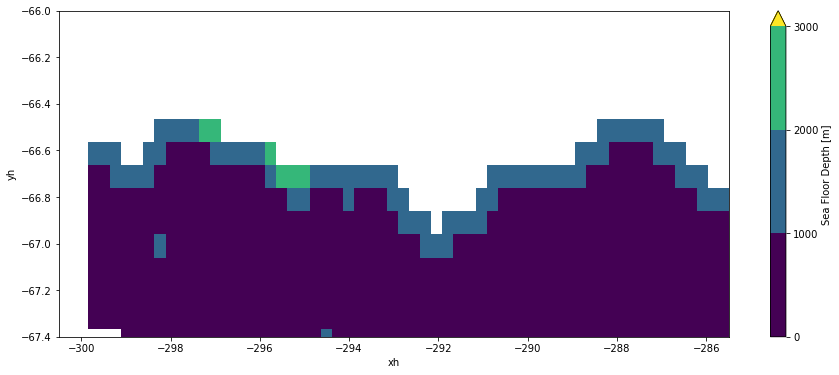

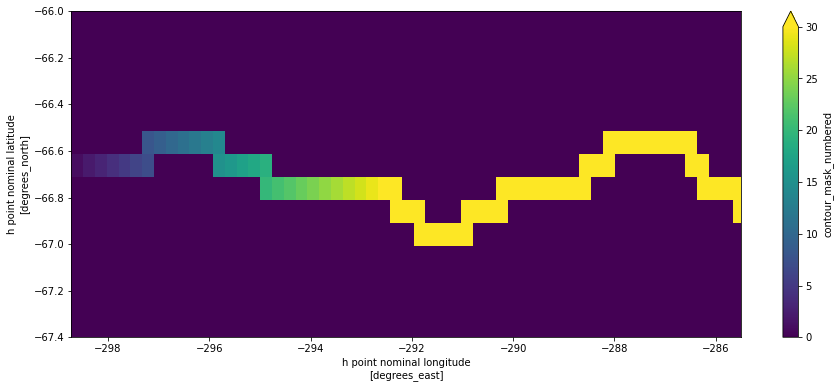

In [85]:
fig, ax = plt.subplots(figsize=(15,6))
ds_all_arrays.contour_mask_numbered.plot(vmax=30)
ax.set_xlim([None,-285.5])
ax.set_ylim([-67.4,-66])
plt.show()

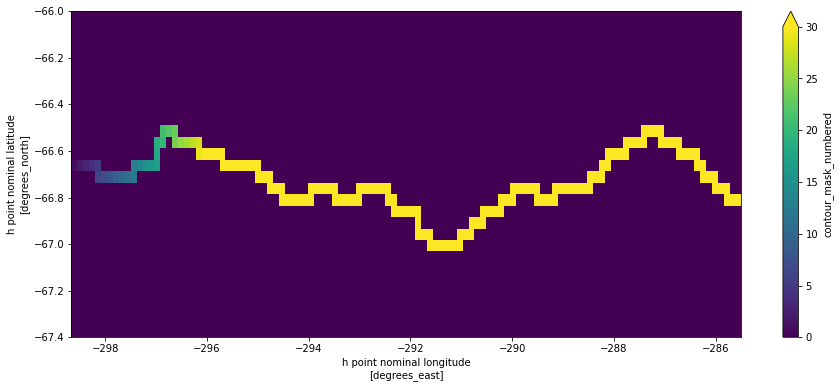

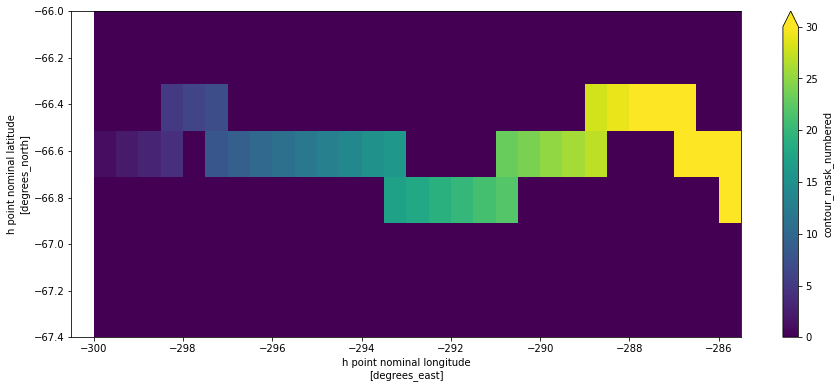

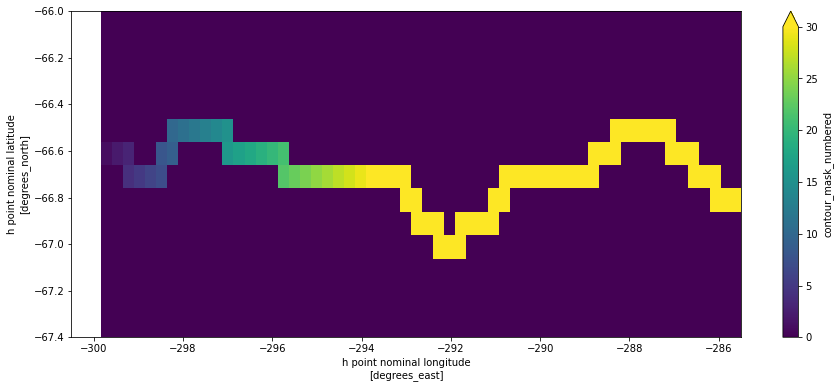

In [86]:
shelf_bathy = shelf_bathy.where(ds_all_arrays.contour_mask_numbered==0)

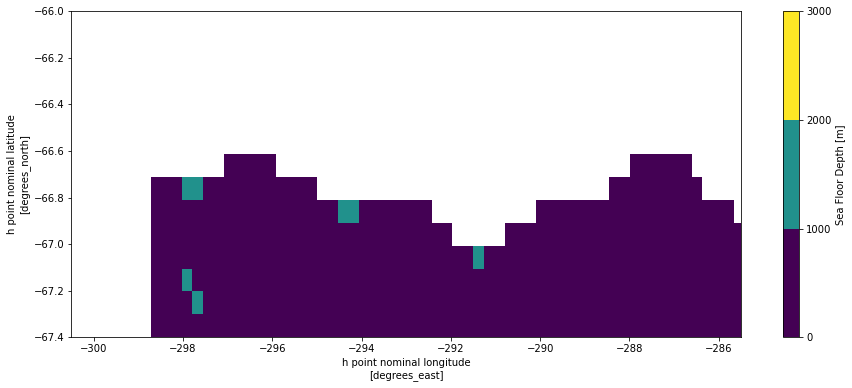

In [87]:
fig, ax = plt.subplots(figsize=(15,6))
shelf_bathy.plot(vmin=0,vmax=3000,levels=4)
ax.set_xlim([-300.5,-285.5])
ax.set_ylim([-67.4,-66])
plt.show()

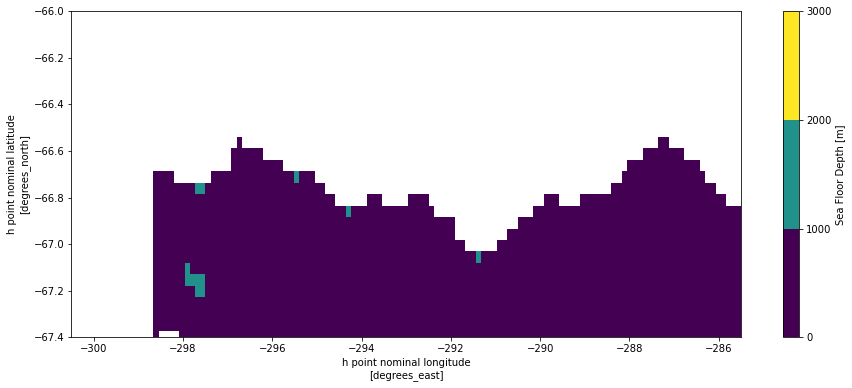

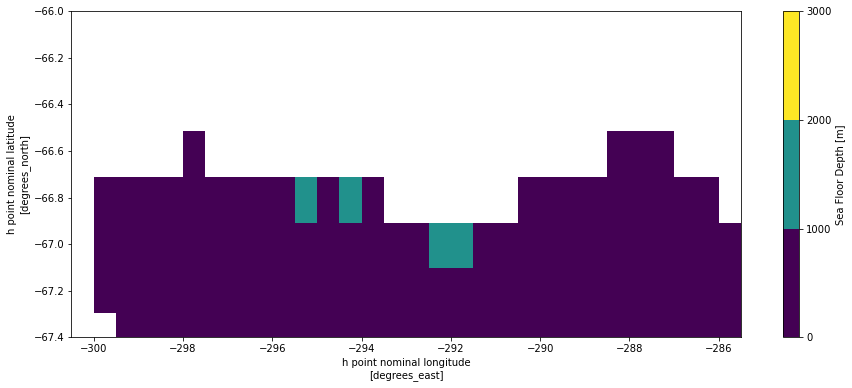

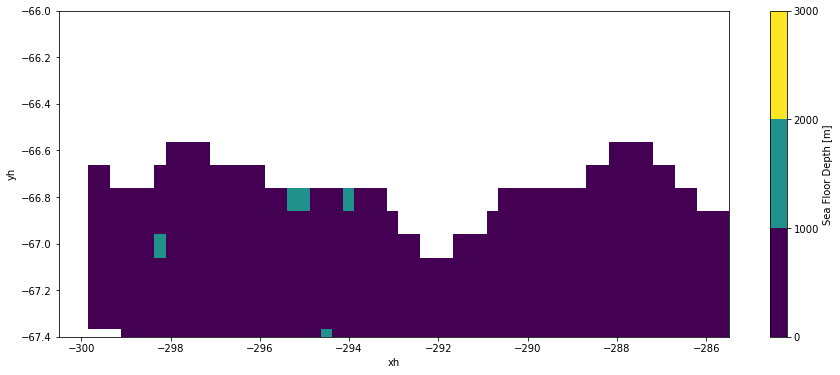

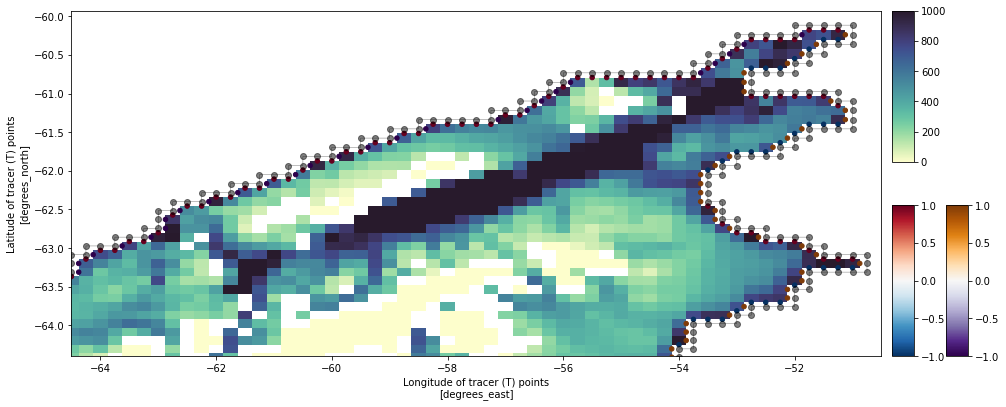

In [95]:
fig, ax = plt.subplots(figsize=(15,6))
fig.subplots_adjust(left=0.1, right=0.85, bottom=0.1, top=0.9)

p1=shelf_bathy.plot(ax=ax, x='geolon', y='geolat', cmap=cmo.deep, vmin=0,vmax=1000, add_colorbar=False)
ax.plot(geolon_index,geolat_index,color='k',ls='-',lw=0.5,alpha=0.5,marker='o')
p2a=ax.scatter(geolon_v_1D,geolat_v_1D,c=vmo_mask_1D,s=20,cmap='RdBu_r',vmin=-1,vmax=1)
p2b=ax.scatter(geolon_u_1D,geolat_u_1D,c=umo_mask_1D,s=20,cmap='PuOr_r',vmin=-1,vmax=1)
#ax.set_xlim([-300.5,-285.5])
#ax.set_ylim([-67.4,-66])
ax.set_xlim([-64.5,-50.5])
ax.set_ylim([-64.4,None])
cax1 = fig.add_axes([0.86, 0.55 , 0.02, 0.35])
cb1 = fig.colorbar(p1, cax=cax1, orientation='vertical')

cax2 = fig.add_axes([0.86, 0.1 , 0.02, 0.35])
cb2a = fig.colorbar(p2a, cax=cax2, orientation='vertical')

cax3 = fig.add_axes([0.91, 0.1 , 0.02, 0.35])
cb2b = fig.colorbar(p2b, cax=cax3, orientation='vertical')
plt.show()

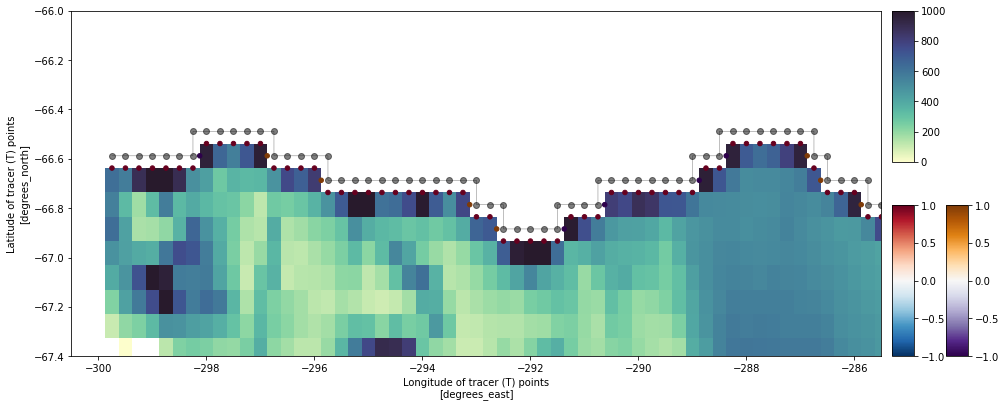

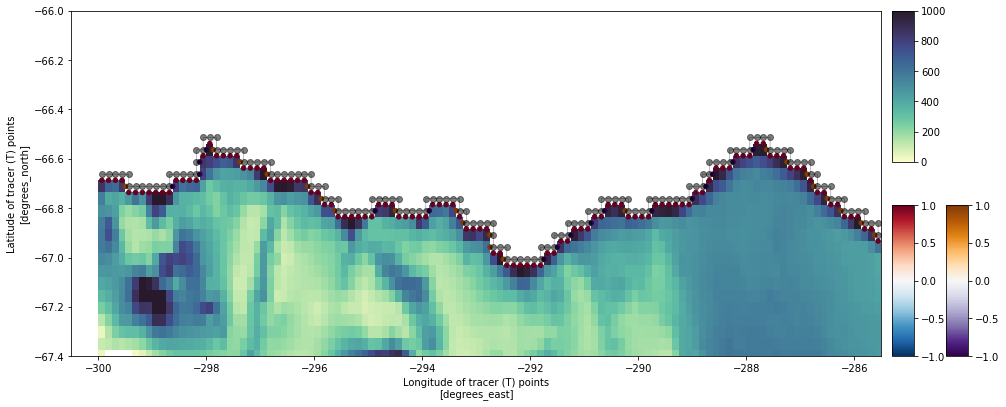

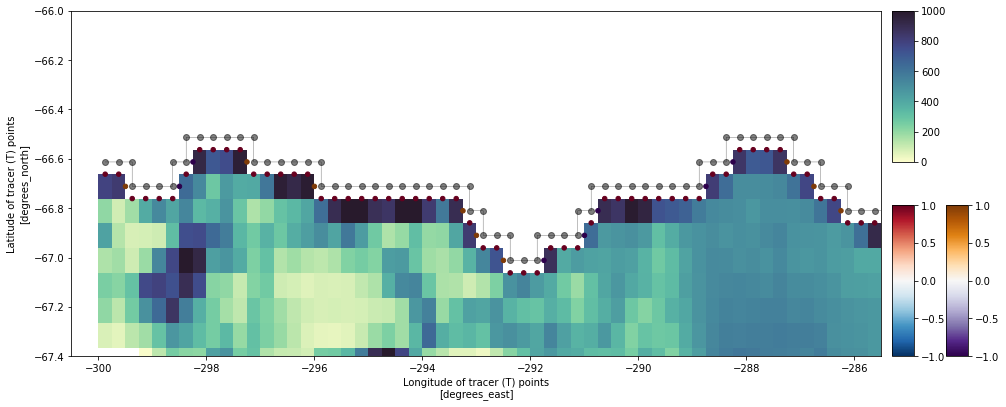

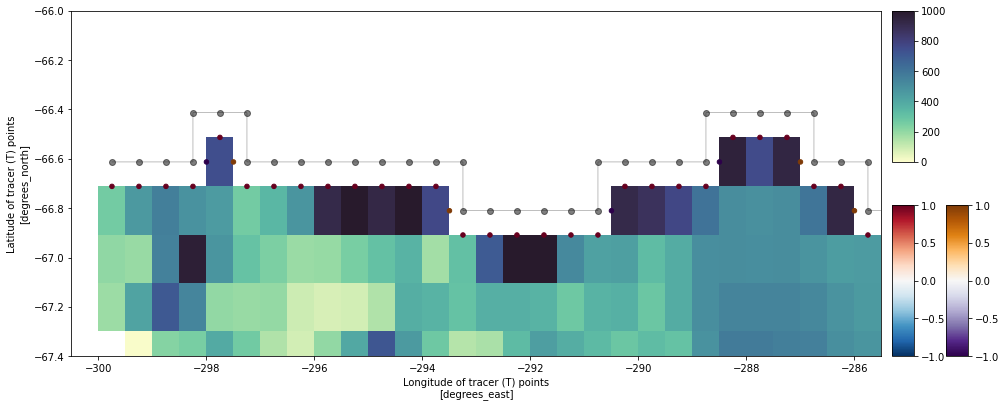

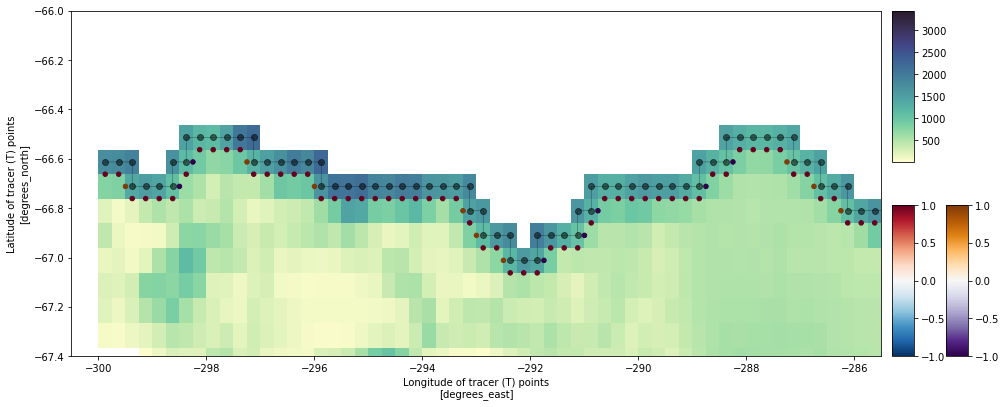